## to do the analysis:
-	iloc warnings update to current version.
-	3d plots with bodyweight
- 	auc plots logy axis 


## Plots for manuscript
Which plots:
-   caffeine clearance / doses
-   caffeine half life / doses/kg
Different variants of plot
- only strict data & remove outliers & rest! (describe the criteria of data selection in legend, i.e. healthy, smoking, ...; and outlier removal!); for males oc=F must be inferred -> check and document;
- create rest/unknown category of all data which has missing smoking or oc information.
- all symbols are circles!, only change colors for subgroups: control, smoking, oc, oc-smoking, rest
- Two variants of plot: (i) only raw outputs and (ii) raw outputs + calculated (used different symbol for calculated)
- check errorbars for dose/kg 
- make plot square
- doses in [mg] and [mg/kg]; clearance in [ml/min]; thalf [hr];
- size of marker according to groupsize
- more concise legend,e.g., control (I=190, G=47, TI=2001)
- remove title, remove grid
- add histograms on y-Axis
- add interpolation curve for groups

- Create same plots with outliers + rest (supplement) & clearly mark the outliers and rest with different symbols;




## Manuscript: 

- update figure 3 second image (strict query) (make image legend and write method section ( how was the image created)
- add overview tables in suplements
- substance diagram on left side (add legend , add method section)


In [1]:
import pandas as pd
import numpy as np
from collections import namedtuple
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import os
plt.style.use('seaborn-white')
import matplotlib
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker



from utils import PkdbModel, abs_idx,rel_idx,group_idx,individual_idx \

plt.rcParams.update({
        'axes.labelsize': '20',
        'axes.labelweight': 'bold',
        'axes.titlesize': 'medium',
        'axes.titleweight': 'bold',
        'legend.fontsize': '20',
        'xtick.labelsize': '20',
        'ytick.labelsize': '20',
        'figure.facecolor': '1.00'
    })


{'token': '4241a1580f26a51f470a716cbb84be132808f5a3'}


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
caffeine_clr = PkdbModel("caffeine_clearance",destination="3-inferred")
caffeine_clr.read()
caffeine_clearance = caffeine_clr.data
caffeine_clearance["outlier"] = False


In [4]:
# filter out outliers probably from same clinical study 

In [5]:
caffeine_clearance.loc[caffeine_clearance["study"]== "Balogh1992","outlier"] = True
caffeine_clearance.loc[caffeine_clearance["study"]== "Harder1988","outlier"] = True
caffeine_clearance.loc[caffeine_clearance["study"]== "Harder1989","outlier"] = True

In [6]:

def control_idx(data):
    return ( data[ ('smoking', 'choice')] == 'N') \
           & (data.outlier == False) \
           & ((data[ ('oral contraceptives', 'choice')] == 'N') | ((data[('oral contraceptives', 'choice')].isnull()) & (data[('medication', 'choice')] == "N")))

def smoking_idx(data):
    return (data[ ('smoking', 'choice')] == 'Y') \
           & (data.outlier == False) \

def oc_idx(data):
    return (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'Y') 

def outlier_idx(data):
    return  data.outlier == True

def rest_idx(data):
    return (~outlier_idx(data) & ~smoking_idx(data)  & ~oc_idx(data) & ~control_idx(data))

In [7]:
class FigureTemplate(object):
    def __init__(self,data_idx,intervention_type, output_type):
        self.data_idx = data_idx,
        self.intervention_type = intervention_type
        self.output_type = output_type
        self.figure=False,
        self.ax = False
    
    def data_subset(self,data):
        return data.loc[self.data_idx]
    
    def create_figure(self, data):
        if len(self.data_subset(data)) > 0:
             self.figure, self.ax  =  plt.subplots(nrows=1, ncols=1, figsize=(15, 15))


In [8]:
PlotCategory =  namedtuple('PlotCategory', ['name','color', 'marker','data_idx'])

def control_idx_strict(data):
    return ( data[ ('smoking', 'choice')] == 'N') \
           & (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'N')
def smoking_idx_strict(data):
    return (data[ ('smoking', 'choice')] == 'Y') \
         & (data[ ('oral contraceptives', 'choice')] == 'N') \
           & (data.outlier == False) 

def oc_idx_strict(data):
    return (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'Y') \
            & (data[ ('smoking', 'choice')] == 'N') 

def oc_smoking_strict(data):
    return (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'Y') \
            & (data[ ('smoking', 'choice')] == 'Y') 

def rest_idx_strict(data):
        return (~control_idx_strict(data) & ~smoking_idx_strict(data) & ~oc_smoking_strict(data)  & ~oc_idx_strict(data) & ~outlier_idx(data))



In [9]:
colors = sns.color_palette("colorblind",n_colors=5)

In [10]:
categories_soft = [              
              PlotCategory(name="UNKOWN", color="darkgray", marker='o', data_idx=rest_idx),
              PlotCategory(name="CONTROL", color=colors[2], marker='o', data_idx=control_idx),
              PlotCategory(name="SMOKING", color=colors[0], marker='o', data_idx=smoking_idx),
              PlotCategory(name="OC", color=colors[3], marker='o', data_idx=oc_idx),
              #PlotCategory(name="outlier", color='red', marker='x', data_idx=outlier_idx),
             ]

In [11]:
categories_strict = [
              PlotCategory(name="UNKOWN", color="darkgray", marker='o', data_idx=rest_idx_strict),
              PlotCategory(name="CONTROL", color=colors[2], marker='o', data_idx=control_idx_strict),
              PlotCategory(name="SMOKING", color=colors[0], marker='o', data_idx=smoking_idx_strict),
              PlotCategory(name="OC", color=colors[3], marker='o', data_idx=oc_idx_strict),
              PlotCategory(name="OC-SMOKING", color=colors[1], marker='o', data_idx=oc_smoking_strict),
              #PlotCategory(name="outlier", color='red', marker='x', data_idx=outlier_idx),
             ]

In [12]:


def create_figures(df_data):
    figure_templates = [FigureTemplate(
        data_idx= abs_idx(df_data,"unit_intervention") & abs_idx(df_data,"unit"),
        intervention_type = "abs",
        output_type = "abs"
                  ),
    FigureTemplate(
        data_idx= rel_idx(df_data,"unit_intervention") & abs_idx(df_data,"unit"),
        intervention_type = "rel",
        output_type = "abs"
                  ),
    FigureTemplate(
        data_idx= abs_idx(df_data,"unit_intervention") & rel_idx(df_data,"unit"),
        intervention_type = "abs",
        output_type = "rel"
                  ),
    FigureTemplate(
        data_idx= rel_idx(df_data,"unit_intervention") & rel_idx(df_data,"unit"),
        intervention_type = "rel",
        output_type = "rel"
                  )
    ]
    
    for figure_template in figure_templates:
        
        figure_template.create_figure(df_data)
    return figure_templates
        
    
    


In [13]:

import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='Roboto Mono',
                                   weight='normal',
                                   style='normal', size=16,) 

category_mapper = {
    "thalf": "half time"
}

def create_plots(df_data,categories,fig_path,pktype, log_y=False):
    
    
    figures = create_figures(df_data)
    
    for figure in figures:
        if figure.ax:
            df_figure = figure.data_subset(df_data)
            
            df_figure_max = max([df_figure["value"].max(),df_figure["mean"].max()])*1.05
            df_figure_x_max =df_figure["value_intervention"].max()*1.05
            
            df_figure_min = min([df_figure["value"].min(),df_figure["mean"].min()])/1.05

        
            df_individual = df_figure[individual_idx(df_data)]
            df_group = df_figure[group_idx(df_data)]

            legend_elements = []
            for plot_category in categories:
                
                
                
                
                df_category = df_individual[plot_category.data_idx(df_individual)]
                
                units = df_category["unit"].unique()
                units_intervention = df_category["unit_intervention"].unique()
                assert len(units) <= 1, units
                try:
                    unit = units[0]
                    unit_intervention = units_intervention[0]
                    
                    y_axis = category_mapper
                    
                    y_axis_label = category_mapper.get(pktype,pktype)

                    figure.ax.set_ylabel(f'{y_axis_label} [{unit}]')
                    figure.ax.set_xlabel(f'dose [{unit_intervention}]')
                    figure.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

                except IndexError: 
                    pass
                
                
                individuals_number = len(df_category)
                
                for calculated, df_individuals in df_category.groupby("calculated"):
                    if calculated:
                        marker = "s"
                    else:
                        marker = plot_category.marker

                    x = df_individuals["value_intervention"]
                    y = df_individuals["value"]
                    figure.ax.scatter(x, y,color=plot_category.color, marker=marker, alpha=0.7,label=None,  s=20)

                

                

                df_category = df_group[plot_category.data_idx(df_group)]
                df_category = df_category[df_category["mean"].notnull()]
                group_number = len(df_category)
                total_group_individuals = 0
                x_group_max = df_category["value_intervention"].max()
                y_group_max = df_category["mean"].max()

                for i, df_row in df_category.iterrows():
                    if df_row["calculated"]:
                        marker = "s"
                    else:
                        marker = plot_category.marker

                    x_group = df_row["value_intervention"]
                    y_group = df_row["mean"]

                    if figure.output_type == "rel":
                        xerr_group = (df_row[("weight","sd")]/df_row[("weight","mean")])*x_group
                    else:
                        xerr_group = 0
                    yerr_group = df_row["se"]
                    group_count = df_row['group_count']
                    total_group_individuals += group_count
                    
                

                    figure.ax.errorbar(x_group, y_group,yerr=yerr_group,xerr=xerr_group, color=plot_category.color, fmt=marker,ms=group_count+5, alpha=0.7)
                    #for i, txt in enumerate(df_category[('study', '')]):
                    txt = df_row[('study', '')]
                    figure.ax.annotate(txt, (x_group+(0.01*x_group_max),
                                      y_group+(0.01*y_group_max)), alpha=0.7)
                    
                label_text = f"{plot_category.name:<10} I: {individuals_number:<3} G: {group_number:<2} TI: {int(total_group_individuals + individuals_number):<3}"
                print(label_text)
                # "
                label = Line2D([0], [0], marker='o', color='w', label=label_text, markerfacecolor=plot_category.color, markersize=10)
                legend_elements.append(label)
                
            legend2_elements = [
                Line2D([0], [0], marker='o', color='w', label="RAW",markerfacecolor="black", markersize=10),
                Line2D([0], [0], marker='s', color='w', label="CALCULATED",markerfacecolor="black", markersize=10)
            ]
            
            legend3_elements = [
                Line2D([0], [10],marker='o', color='w', label="1",markerfacecolor="black", markersize=5+1),
                Line2D([0], [20], marker='o', color='w', label="10",markerfacecolor="black", markersize=5+10),
                Line2D([0], [50], marker='o', color='w', label="30",markerfacecolor="black", markersize=5+30),
]

            #figure.ax.set_title(pktype.capitalize())
            figure.ax.set_xlim(left=0, right=df_figure_x_max)
            #figure.ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            figure.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
            
            leg1 = figure.ax.legend(handles=legend_elements, prop=font)
            
            leg2 = figure.ax.legend(handles=legend2_elements, prop = font, loc ="upper left")
            leg3 = figure.ax.legend(handles=legend3_elements, prop=font,labelspacing=1.3 ,loc=("center right"))
            leg3.set_title(title="GROUP SIZE",prop=font )
            figure.ax.add_artist(leg2)
            figure.ax.add_artist(leg1)

            if log_y:
                figure.ax.set_yscale("log") 
                figure.ax.set_ylim(bottom=df_figure_min, top=df_figure_max)
            else:
                figure.ax.set_ylim(bottom=0, top=df_figure_max)



            figure.figure.savefig(os.path.join(fig_path,f"{pktype}_{figure.output_type}-vs-dosing_{figure.intervention_type}.svg"), bbox_inches="tight")



                

   

In [14]:
print(len(caffeine_clearance[caffeine_clearance["calculated"] == True]))
print(len(caffeine_clearance[caffeine_clearance["calculated"] == False]))

507
1757


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 29  G: 41 TI: 359
CONTROL    I: 204 G: 62 TI: 863
SMOKING    I: 91  G: 19 TI: 373
OC         I: 53  G: 6  TI: 105


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 14  G: 37 TI: 297
CONTROL    I: 112 G: 48 TI: 601
SMOKING    I: 74  G: 13 TI: 302
OC         I: 33  G: 4  TI: 65 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 53  G: 43 TI: 415
CONTROL    I: 189 G: 54 TI: 754
SMOKING    I: 86  G: 16 TI: 341
OC         I: 42  G: 4  TI: 74 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 18  G: 37 TI: 301
CONTROL    I: 118 G: 51 TI: 625
SMOKING    I: 81  G: 14 TI: 315
OC         I: 33  G: 4  TI: 65 


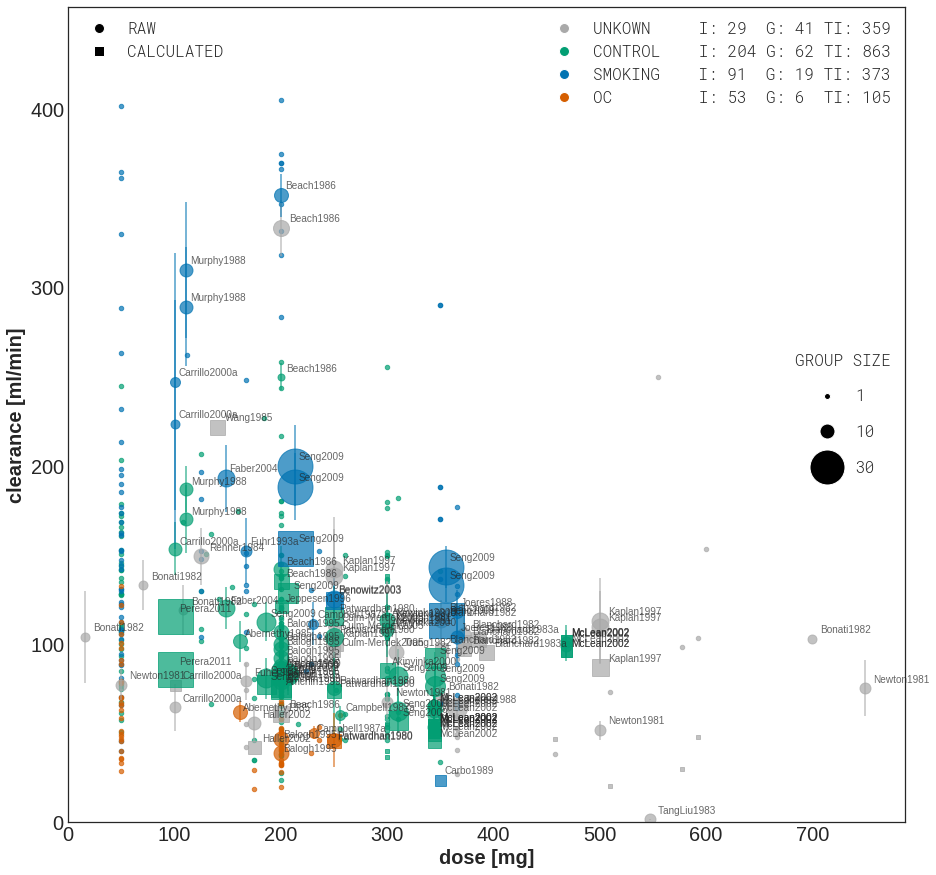

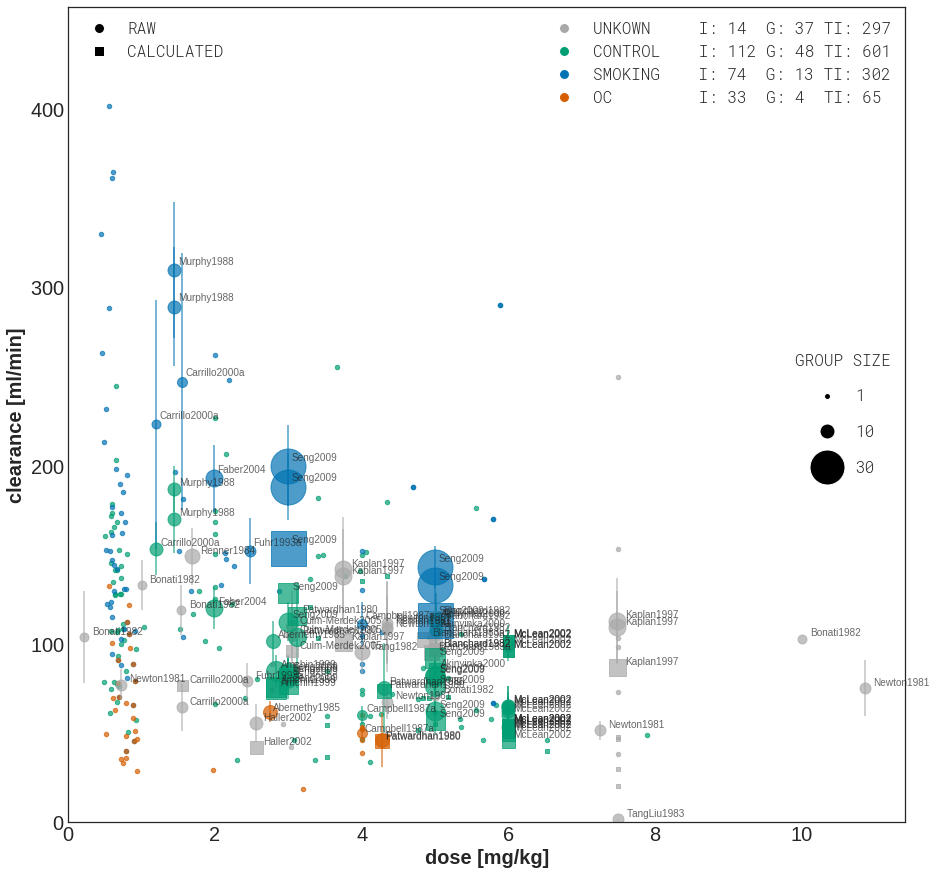

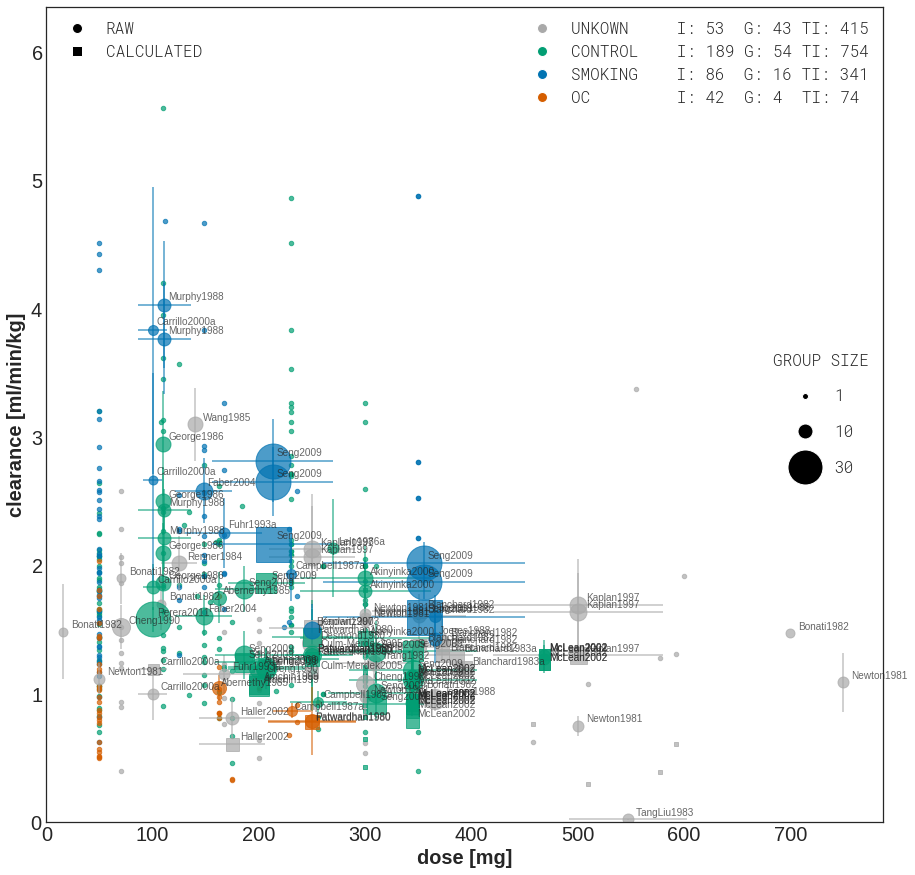

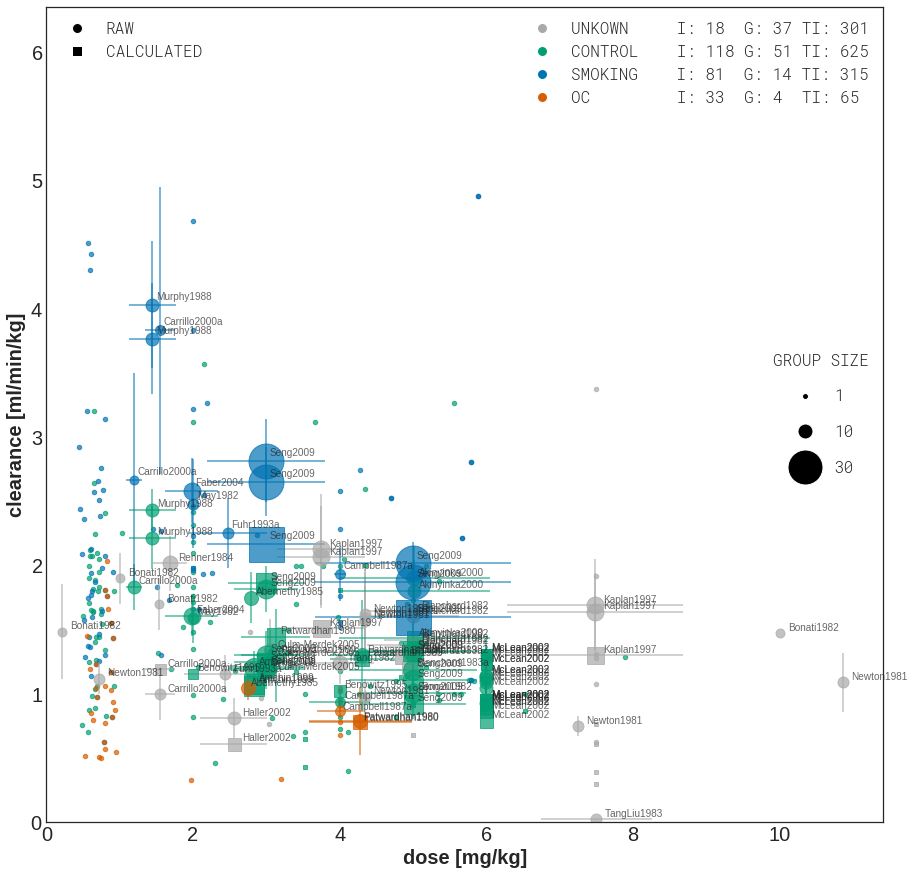

In [15]:
create_plots(caffeine_clearance,categories_soft,"reports/soft","clearance")

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 57  G: 52 TI: 472
CONTROL    I: 190 G: 56 TI: 803
SMOKING    I: 68  G: 14 TI: 311
OC         I: 44  G: 6  TI: 96 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 32  G: 45 TI: 381
CONTROL    I: 99  G: 43 TI: 544
SMOKING    I: 60  G: 10 TI: 266
OC         I: 24  G: 4  TI: 56 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 71  G: 52 TI: 507
CONTROL    I: 176 G: 49 TI: 697
SMOKING    I: 72  G: 12 TI: 297
OC         I: 33  G: 4  TI: 65 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 36  G: 45 TI: 385
CONTROL    I: 105 G: 46 TI: 568
SMOKING    I: 67  G: 11 TI: 279
OC         I: 24  G: 4  TI: 56 
OC-SMOKING I: 9   G: 0  TI: 9  


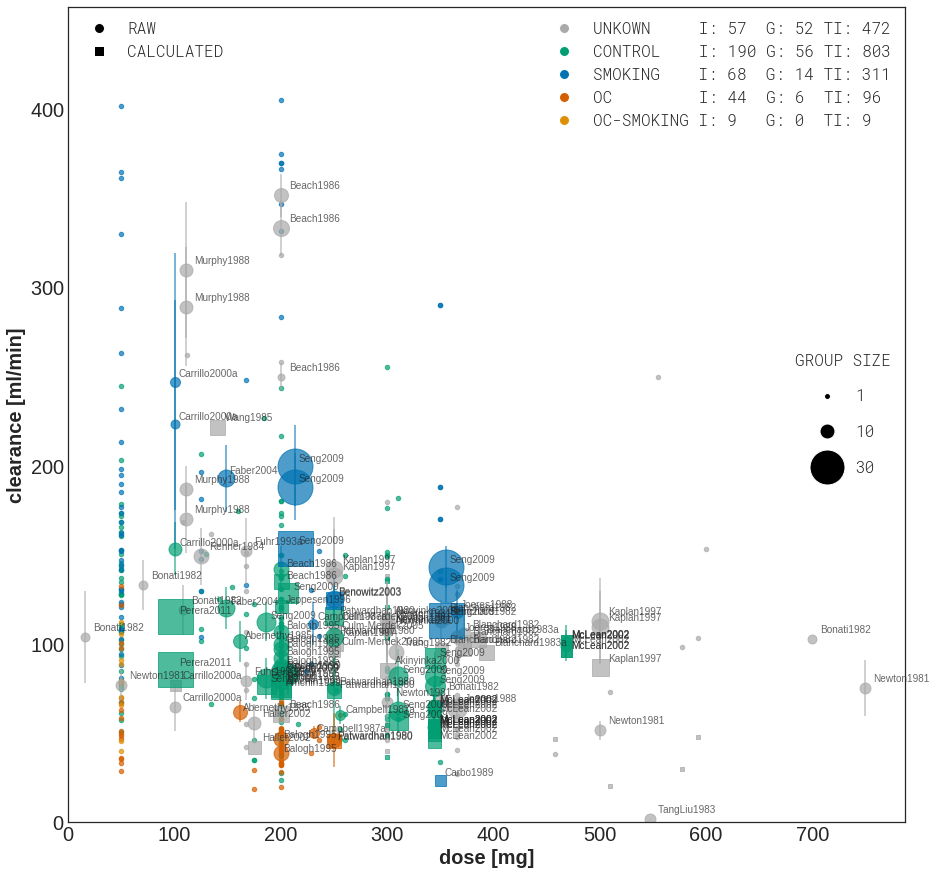

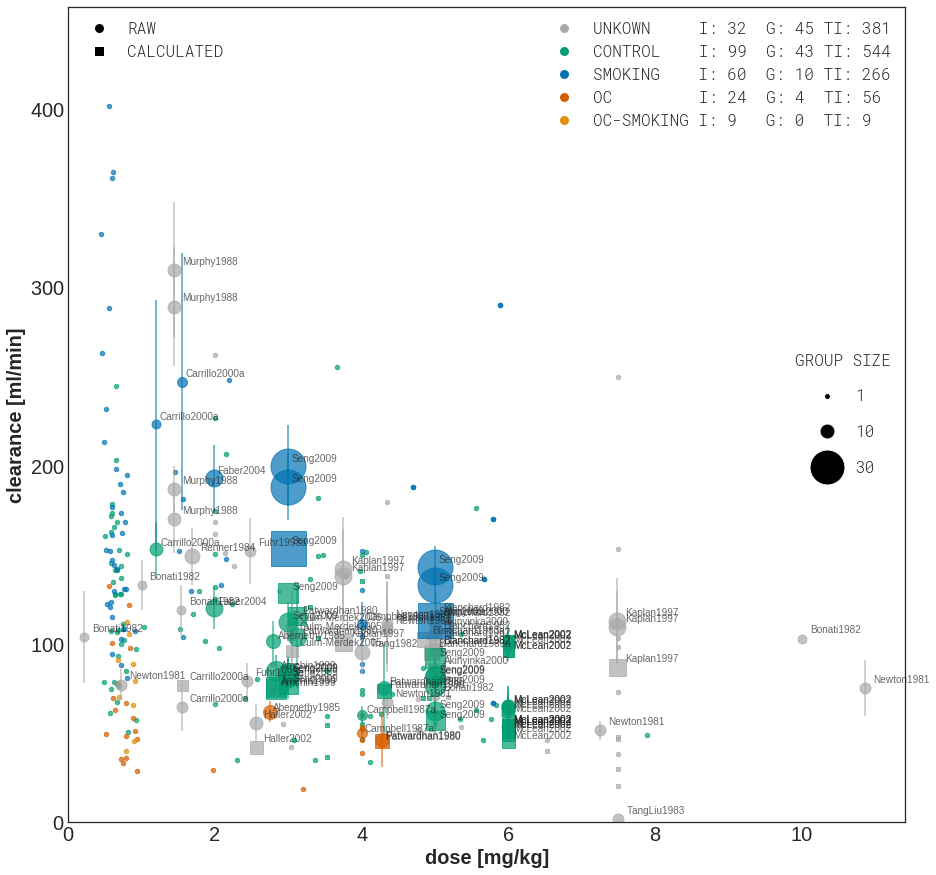

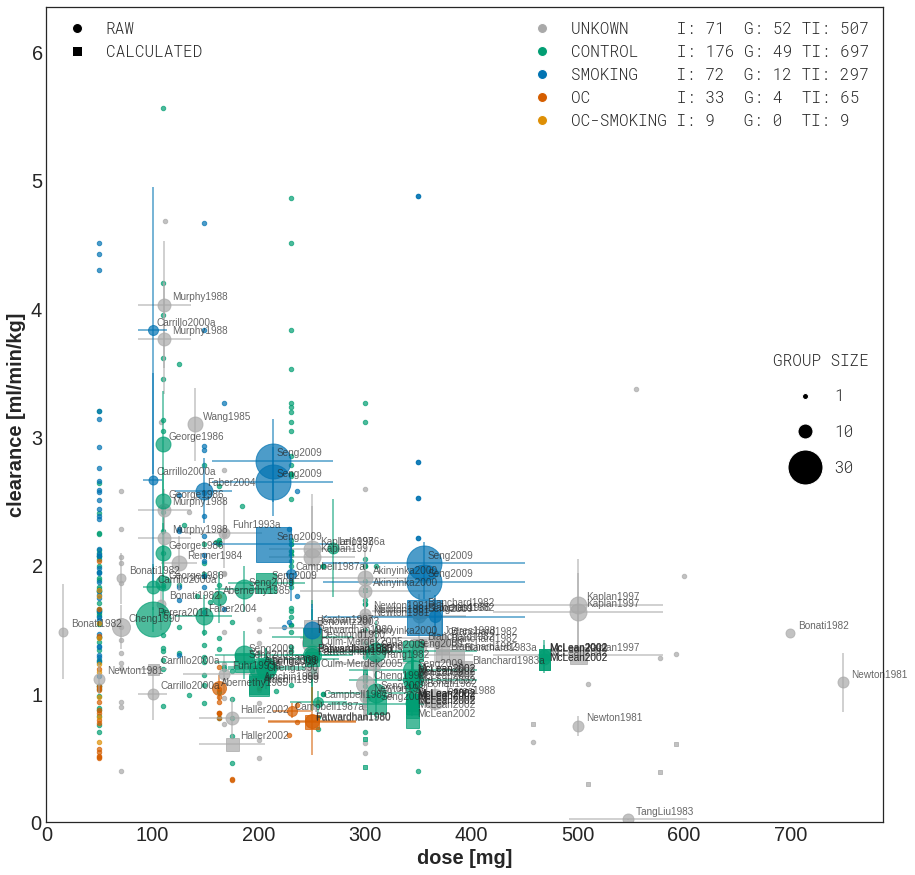

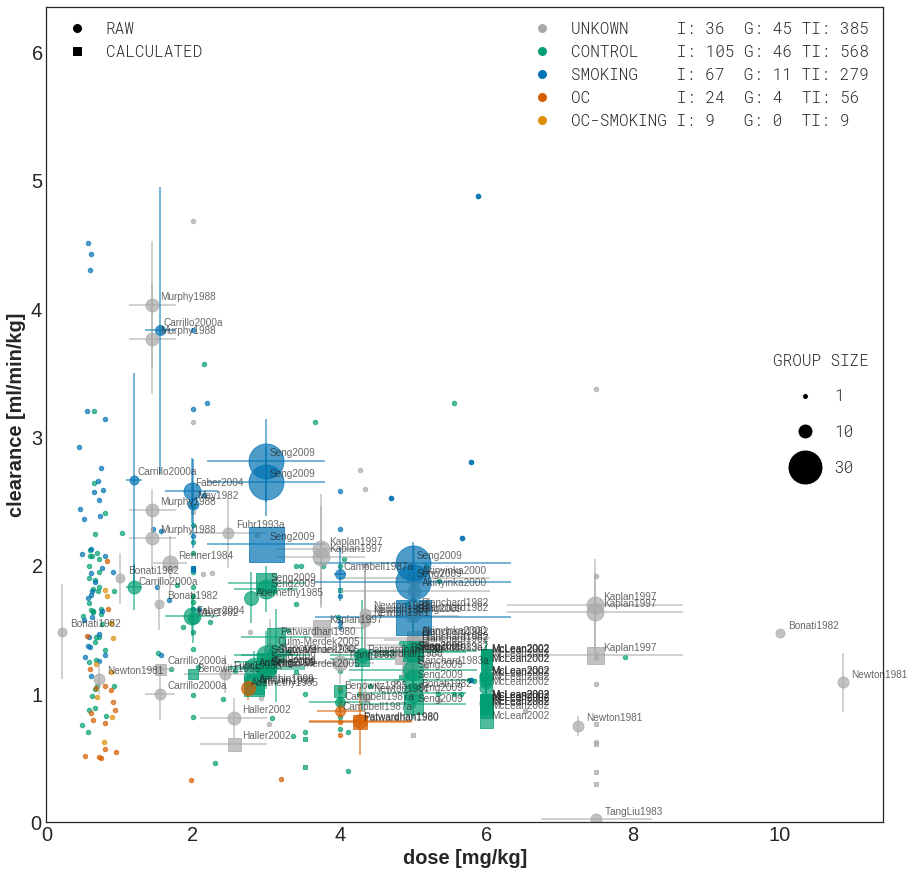

In [16]:
create_plots(caffeine_clearance,categories_strict,"reports/strict","clearance")

In [17]:
caffeine_clearance[abs_idx(caffeine_clearance,"unit_intervention") & abs_idx(caffeine_clearance,"unit")].groupby("subject_type").count()

study  output_type   pk  access  measurement_type  tissue  \
subject_type                                                              
group           139          139  139     139               139     139   
individual      512          512  512     512               512     512   

              allowed_users  substance  interventions  raw_pk  ...  \
subject_type                                                   ...   
group                   139        139            139     139  ...   
individual              512        512            512     512  ...   

              (cyp2d6 variant, count)  (lean body mass, count)  \
subject_type                                                     
group                               0                        0   
individual                          0                        0   

              (lean body mass, mean)  (lean body mass, sd)  \
subject_type                                                 
group                              0                     0   
individual                         0                     0   

              (lean body mass, unit)  (fat weight, count)  (fat weight, mean)  \
subject_type                                                                    
group                              0                   20                  20   
individual                         0                    0                   0   

              (fat weight, se)  (fat weight, unit)  outlier  
subject_type                                                 
group                       20                  20      139  
individual                   0                   0      512  

[2 rows x 239 columns]

In [18]:
caffeine_thf = PkdbModel("caffeine_thalf",destination="3-inferred")
caffeine_thf.read()
caffeine_thalf = caffeine_thf.data
caffeine_thalf["outlier"] = False
caffeine_thalf.loc[caffeine_thalf["study"]== "Balogh1992","outlier"] = True
caffeine_thalf.loc[caffeine_thalf["study"]== "Harder1988","outlier"] = True
caffeine_thalf.loc[caffeine_thalf["study"]== "Harder1989","outlier"] = True

In [19]:
caffeine_thalf.groupby(["calculated","outlier"]).get_group((True,False))[["study","value_intervention","unit_intervention","unit","value","mean"]]

study  value_intervention unit_intervention   unit  value  \
148     Akinyinka2000          300.000000                mg     hr    NaN   
152        Amchin1999          200.000000                mg     hr    NaN   
153        Amchin1999          200.000000                mg     hr    NaN   
170         Beach1986          200.000000                mg     hr    NaN   
171         Beach1986          200.000000                mg     hr    NaN   
175      Benowitz2003          250.000000                mg     hr    NaN   
185     Blanchard1982            5.000000             mg/kg     hr    NaN   
188     Blanchard1982            5.000000             mg/kg     hr    NaN   
189     Blanchard1982            5.000000             mg/kg     hr    NaN   
192     Blanchard1982            5.000000             mg/kg     hr    NaN   
193      Benowitz1995            2.000000             mg/kg     hr    NaN   
194      Benowitz1995            4.000000             mg/kg     hr    NaN   
195         Carbo1989          350.000000                mg     hr    NaN   
208        Bonati1982            5.000000             mg/kg     hr   6.61   
209        Bonati1982            5.000000             mg/kg     hr   8.62   
215        Bonati1982            5.000000             mg/kg     hr   4.70   
216        Bonati1982            5.000000             mg/kg     hr   4.20   
217     Carrillo2000a          100.000000                mg     hr    NaN   
235   Culm-Merdek2005          250.000000                mg     hr    NaN   
236    Blanchard1983a            4.850000             mg/kg     hr    NaN   
237    Blanchard1983a            4.940000             mg/kg     hr    NaN   
263        Haller2002          175.000000                mg     hr    NaN   
343        Kaplan1997          500.000000                mg     hr    NaN   
344        Kaplan1997          250.000000                mg     hr    NaN   
349      Jeppesen1996          200.000000                mg     hr    NaN   
350        McLean2002            6.000000             mg/kg     hr    NaN   
351        McLean2002            6.000000             mg/kg     hr    NaN   
352        McLean2002            6.000000             mg/kg     hr    NaN   
354        McLean2002            6.000000             mg/kg     hr    NaN   
358        McLean2002            6.000000             mg/kg     hr    NaN   
...               ...                 ...               ...    ...    ...   
1959       Haller2002            2.554745             mg/kg  hr/kg    NaN   
1962       Kaplan1997            7.485030             mg/kg  hr/kg    NaN   
1963       Kaplan1997            3.742515             mg/kg  hr/kg    NaN   
1975   Patwardhan1980            3.125000             mg/kg  hr/kg    NaN   
1977   Patwardhan1980            4.280822             mg/kg  hr/kg    NaN   
1979   Patwardhan1980            4.310345             mg/kg  hr/kg    NaN   
1985    Blanchard1982          351.000000                mg  hr/kg    NaN   
1988    Blanchard1982          351.000000                mg  hr/kg    NaN   
1989    Blanchard1982          372.000000                mg  hr/kg    NaN   
1992    Blanchard1982          372.000000                mg  hr/kg    NaN   
1999   Blanchard1983a          385.575000                mg  hr/kg    NaN   
2000   Blanchard1983a          392.730000                mg  hr/kg    NaN   
2001       McLean2002          344.400000                mg  hr/kg    NaN   
2002       McLean2002          344.400000                mg  hr/kg    NaN   
2003       McLean2002          344.400000                mg  hr/kg    NaN   
2005       McLean2002          344.400000                mg  hr/kg    NaN   
2009       McLean2002          344.400000                mg  hr/kg    NaN   
2010       McLean2002          344.400000                mg  hr/kg    NaN   
2011       McLean2002          344.400000                mg  hr/kg    NaN   
2014       McLean2002          344.400000                mg  hr/kg    NaN   
2015       M

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 34  G: 52 TI: 470
CONTROL    I: 175 G: 59 TI: 820
SMOKING    I: 68  G: 11 TI: 239
OC         I: 33  G: 6  TI: 85 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 36  G: 41 TI: 352
CONTROL    I: 105 G: 43 TI: 524
SMOKING    I: 67  G: 8  TI: 207
OC         I: 24  G: 4  TI: 56 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 32  G: 41 TI: 348
CONTROL    I: 99  G: 40 TI: 500
SMOKING    I: 60  G: 7  TI: 194
OC         I: 24  G: 4  TI: 56 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 32  G: 41 TI: 348
CONTROL    I: 99  G: 40 TI: 500
SMOKING    I: 60  G: 7  TI: 194
OC         I: 24  G: 4  TI: 56 
OC-SMOKING I: 9   G: 0  TI: 9  


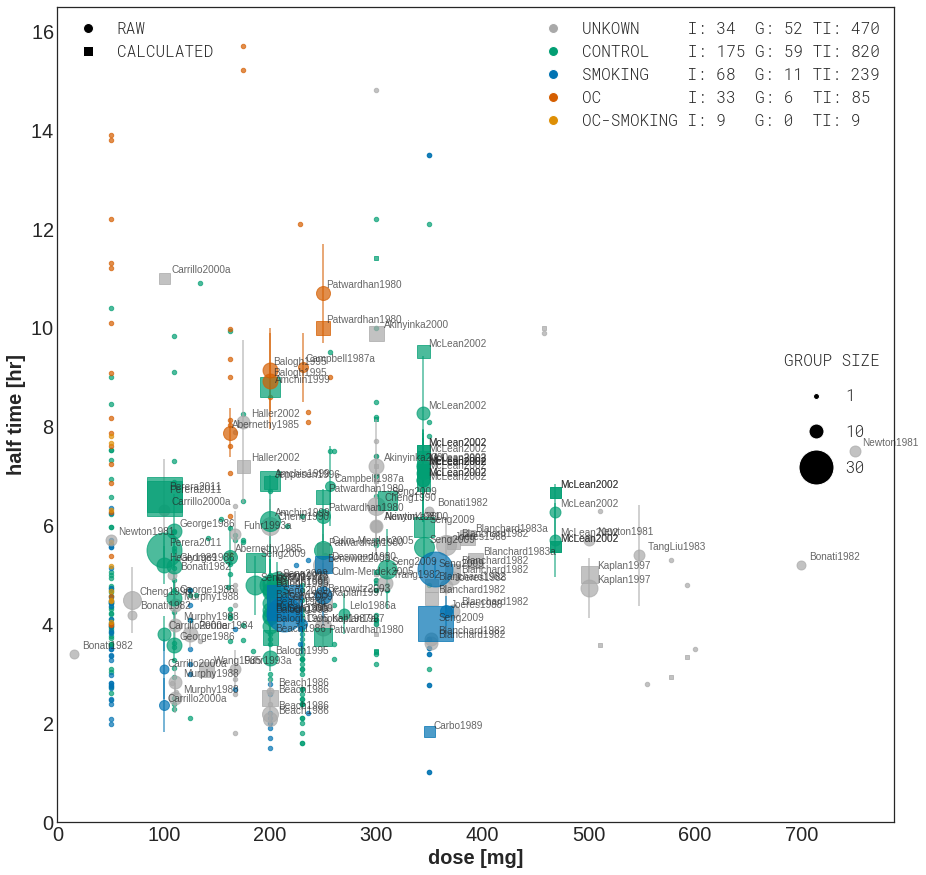

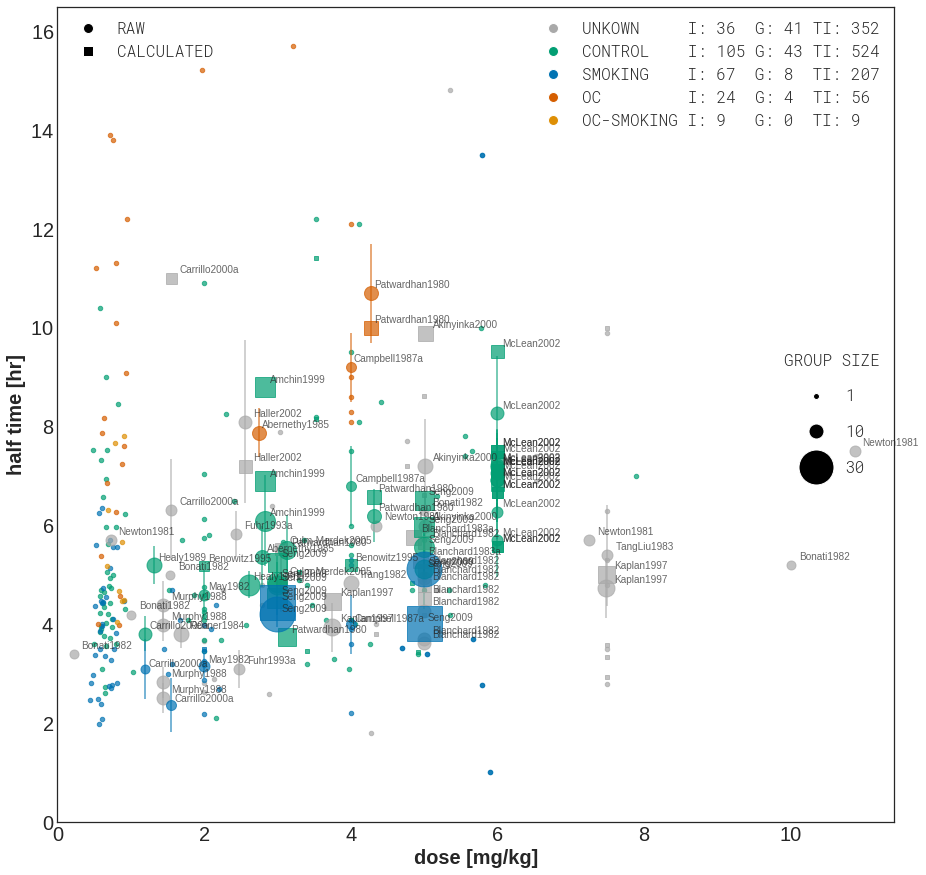

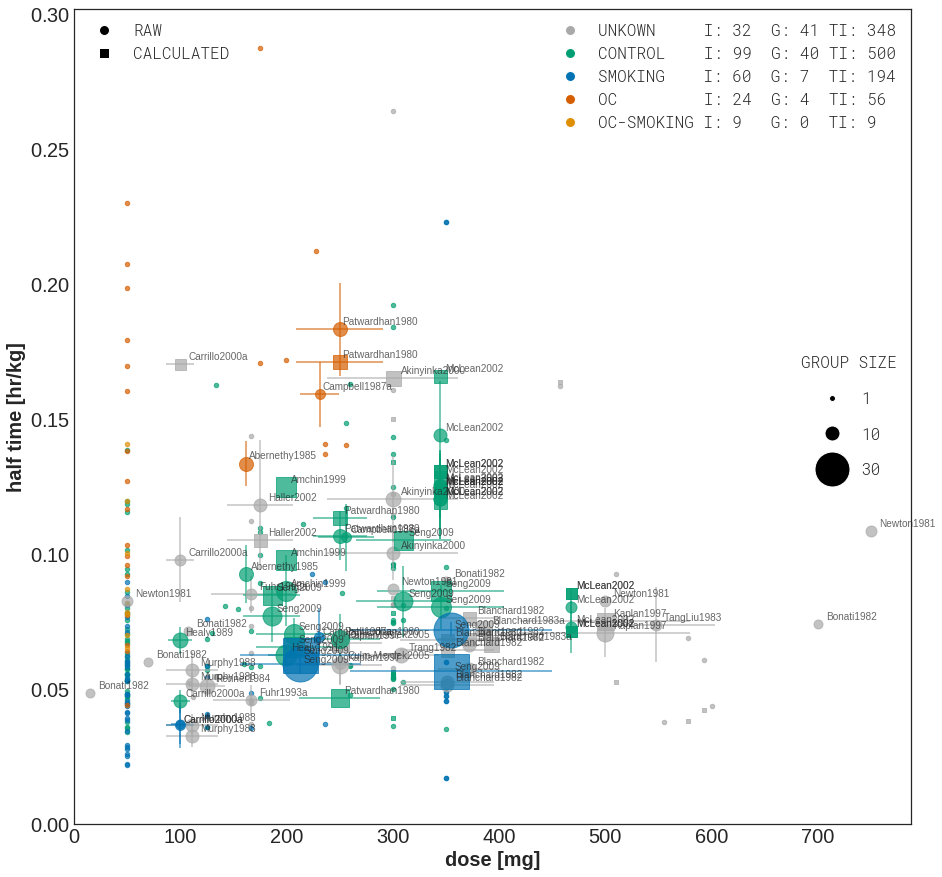

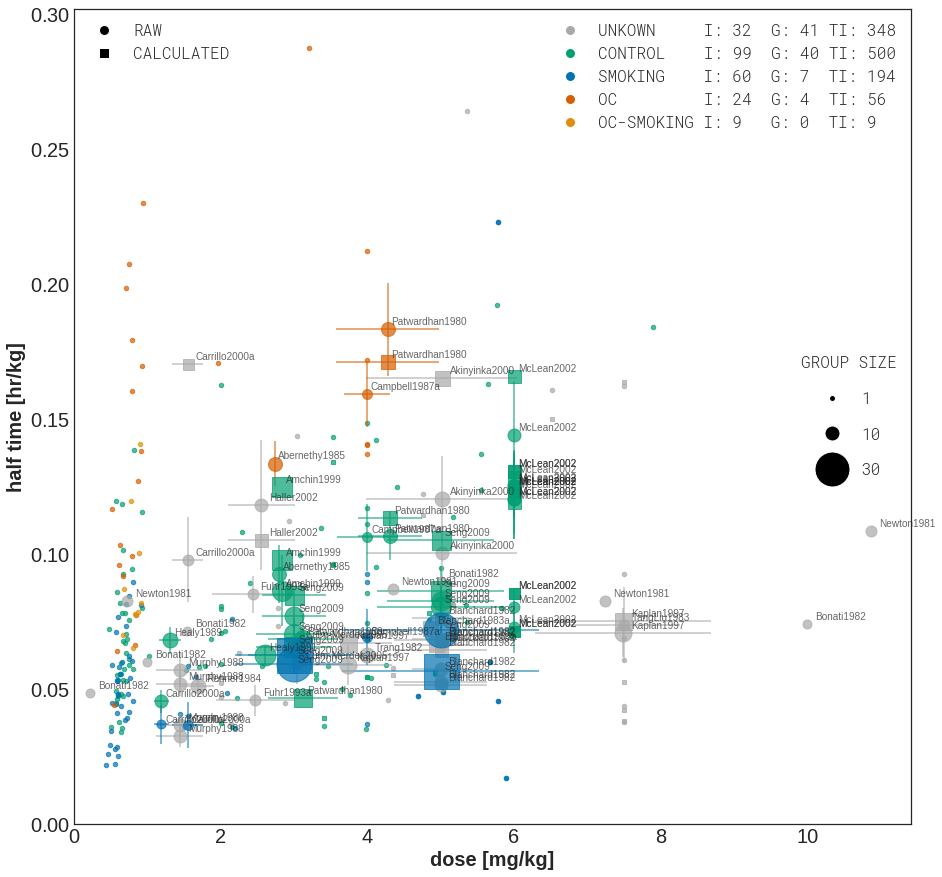

In [20]:
create_plots(caffeine_thalf,categories_strict,"reports/strict","thalf")

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 14  G: 41 TI: 365
CONTROL    I: 189 G: 65 TI: 880
SMOKING    I: 83  G: 16 TI: 293
OC         I: 42  G: 6  TI: 94 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 18  G: 33 TI: 268
CONTROL    I: 118 G: 48 TI: 581
SMOKING    I: 81  G: 11 TI: 243
OC         I: 33  G: 4  TI: 65 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 14  G: 33 TI: 264
CONTROL    I: 112 G: 45 TI: 557
SMOKING    I: 74  G: 10 TI: 230
OC         I: 33  G: 4  TI: 65 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 14  G: 33 TI: 264
CONTROL    I: 112 G: 45 TI: 557
SMOKING    I: 74  G: 10 TI: 230
OC         I: 33  G: 4  TI: 65 


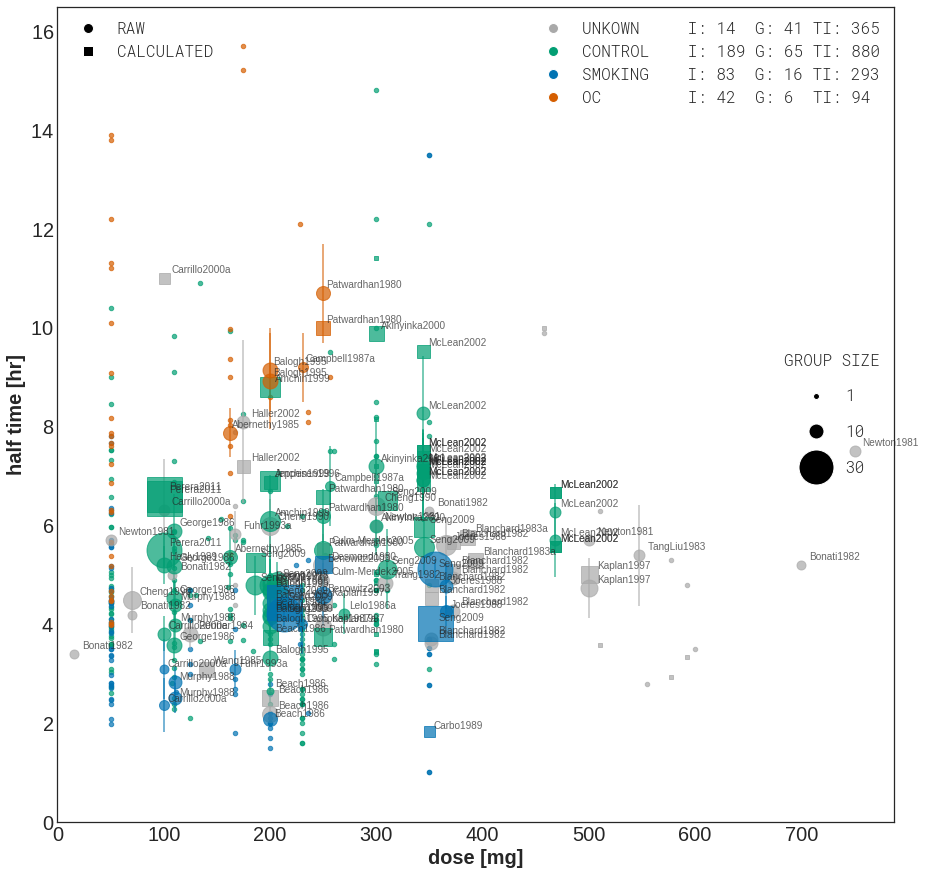

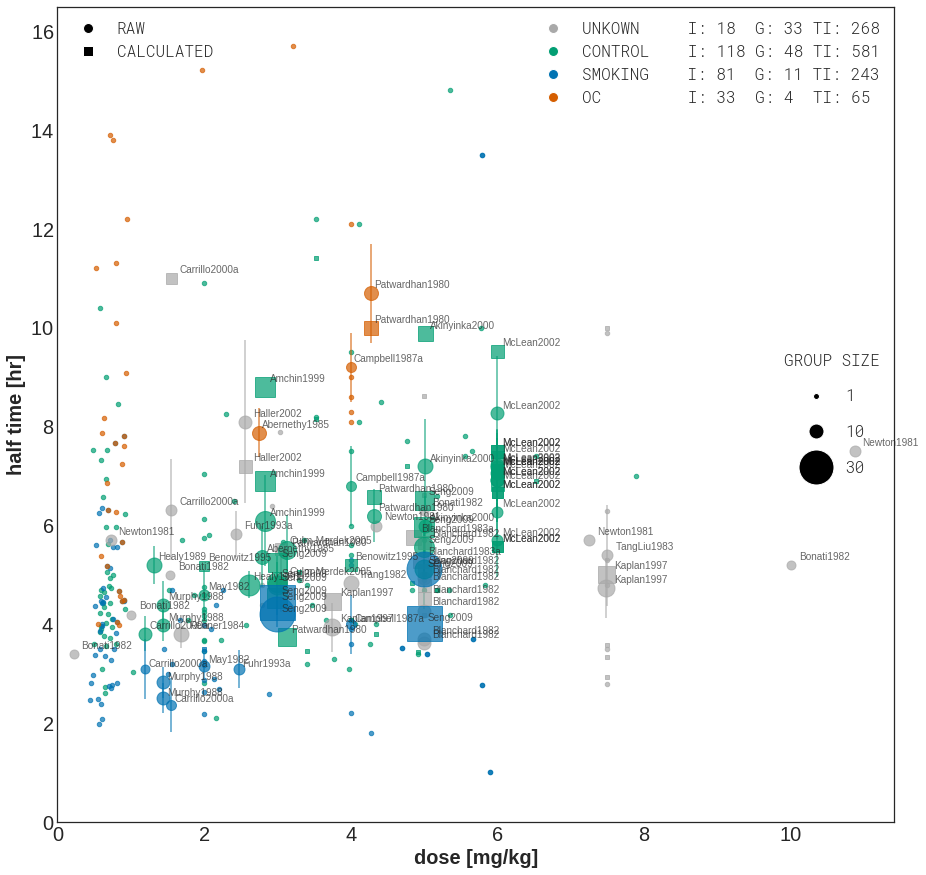

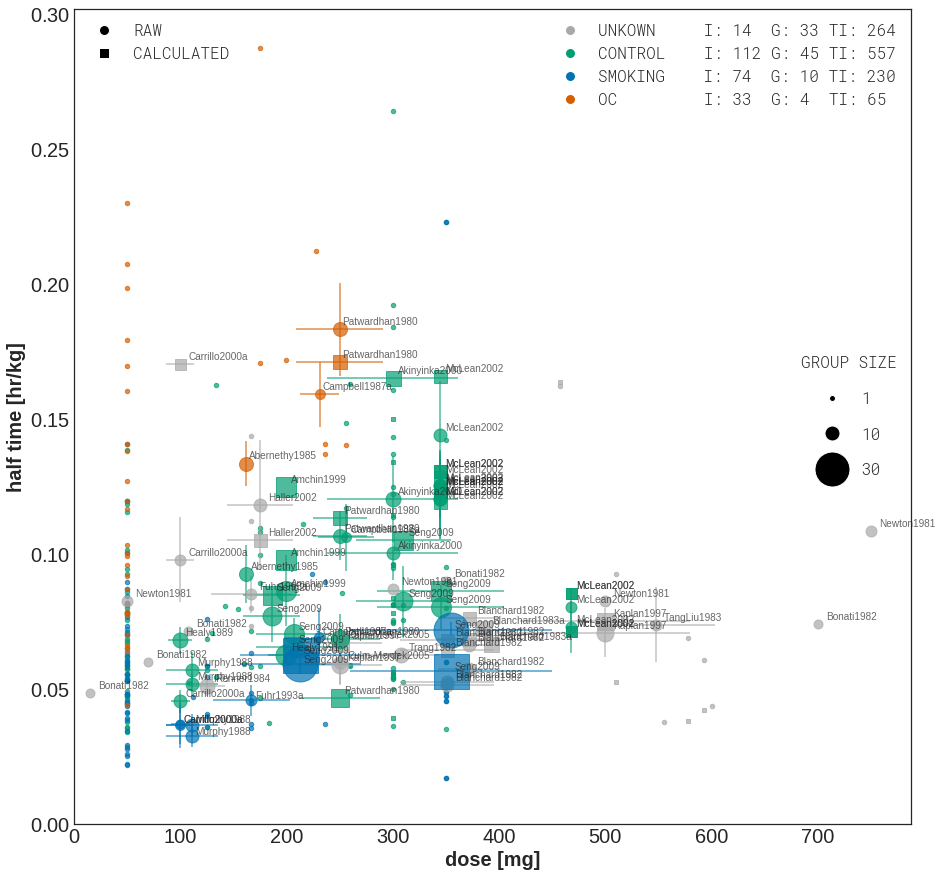

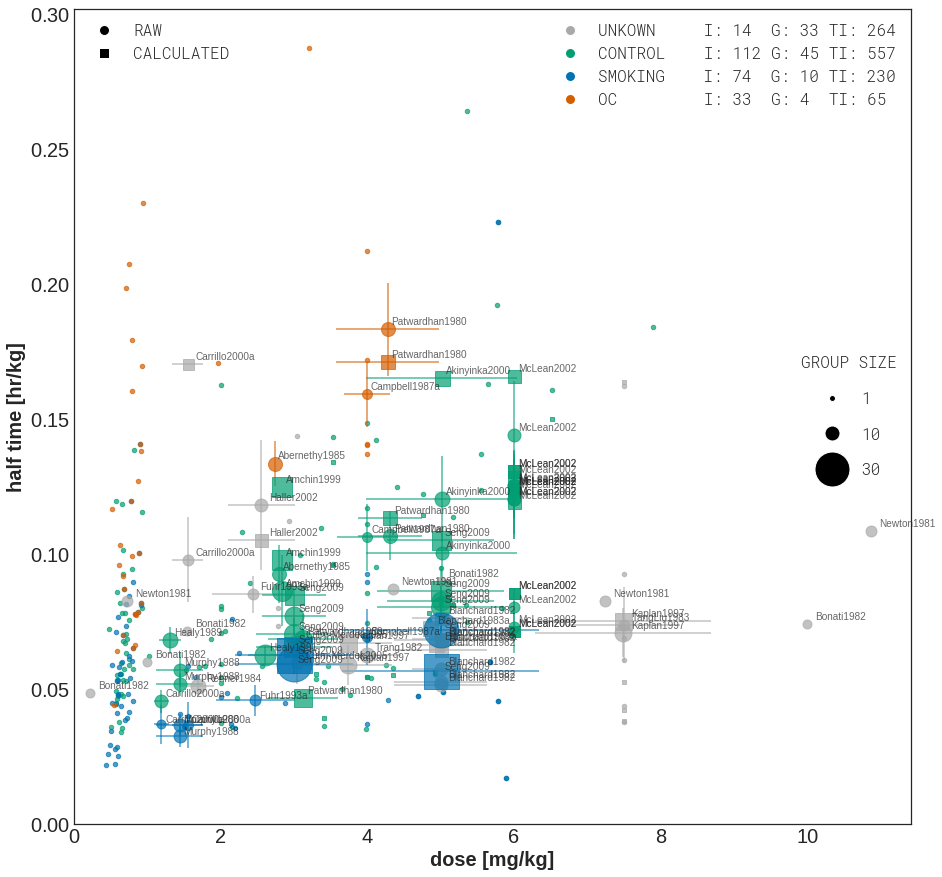

In [21]:
create_plots(caffeine_thalf,categories_soft,"reports/soft","thalf")

In [22]:
caffeine_mx = PkdbModel("caffeine_tmax",destination="3-inferred")
caffeine_mx.read()
caffeine_max = caffeine_mx.data
caffeine_max["outlier"] = False
caffeine_max.loc[caffeine_max["study"]== "Balogh1992","outlier"] = True
caffeine_max.loc[caffeine_max["study"]== "Harder1988","outlier"] = True
caffeine_max.loc[caffeine_max["study"]== "Harder1989","outlier"] = True


In [23]:
caffeine_max.groupby(["unit","unit_intervention"]).apply(len)

unit             unit_intervention
hour             gram                 266
                 gram / kilogram      203
hour / kilogram  gram                 182
                 gram / kilogram      182
dtype: int64

{'token': '4241a1580f26a51f470a716cbb84be132808f5a3'}


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 11  G: 27 TI: 250
CONTROL    I: 62  G: 50 TI: 630
SMOKING    I: 20  G: 9  TI: 128
OC         I: 2   G: 4  TI: 40 
OC-SMOKING I: 0   G: 0  TI: 0  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 13  G: 22 TI: 209
CONTROL    I: 19  G: 38 TI: 377
SMOKING    I: 19  G: 7  TI: 103
OC         I: 2   G: 2  TI: 20 
OC-SMOKING I: 0   G: 0  TI: 0  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 9   G: 22 TI: 205
CONTROL    I: 13  G: 35 TI: 353
SMOKING    I: 12  G: 6  TI: 90 
OC         I: 2   G: 2  TI: 20 
OC-SMOKING I: 0   G: 0  TI: 0  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 9   G: 22 TI: 205
CONTROL    I: 13  G: 35 TI: 353
SMOKING    I: 12  G: 6  TI: 90 
OC         I: 2   G: 2  TI: 20 
OC-SMOKING I: 0   G: 0  TI: 0  


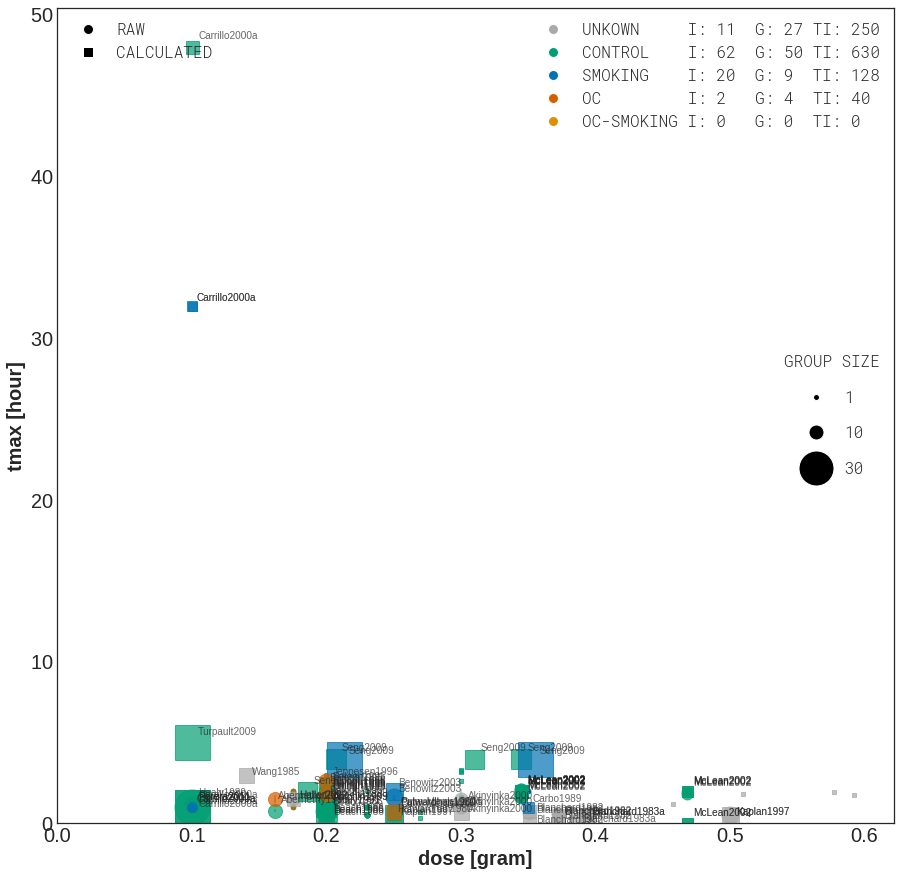

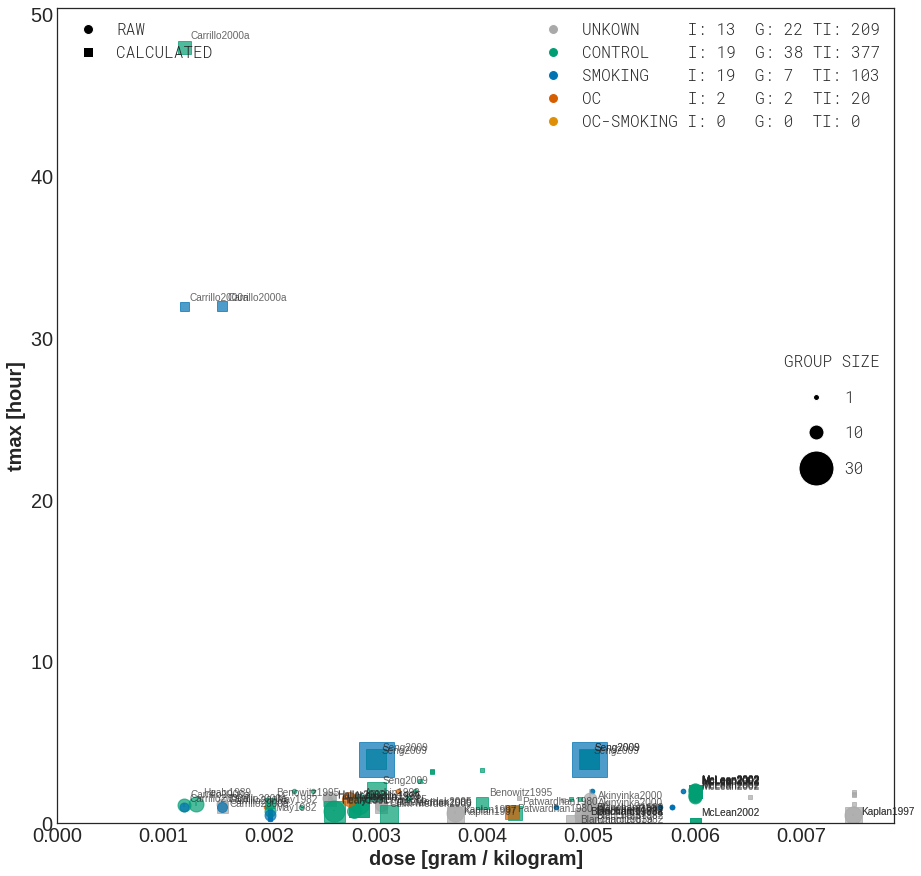

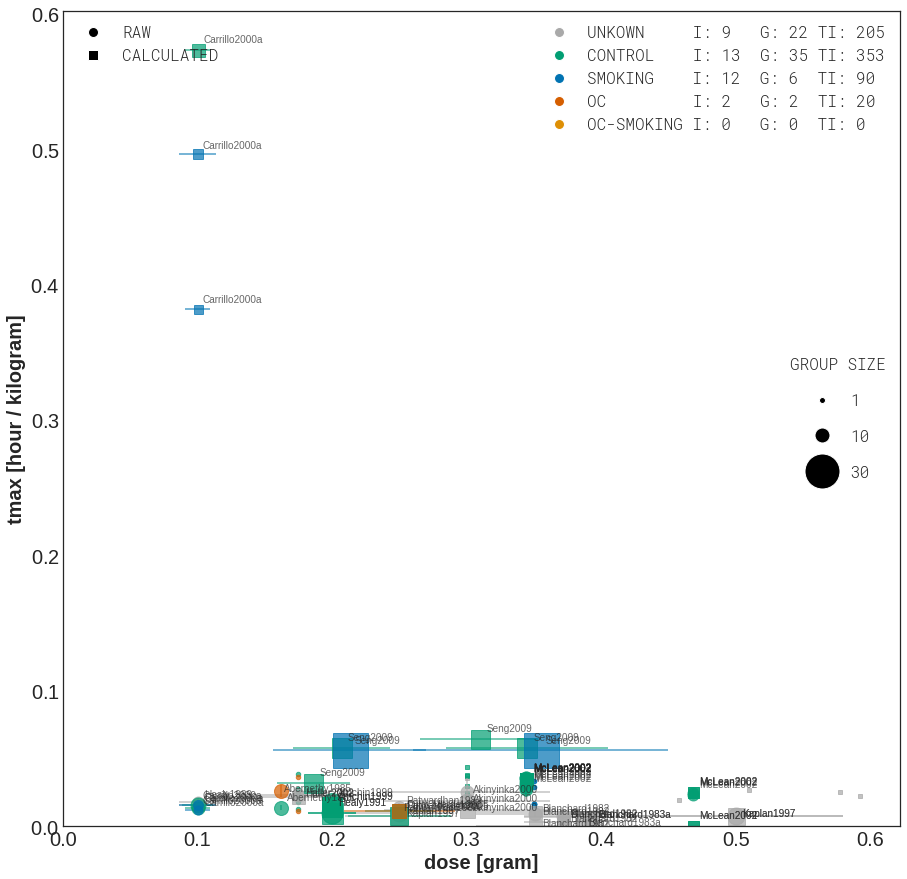

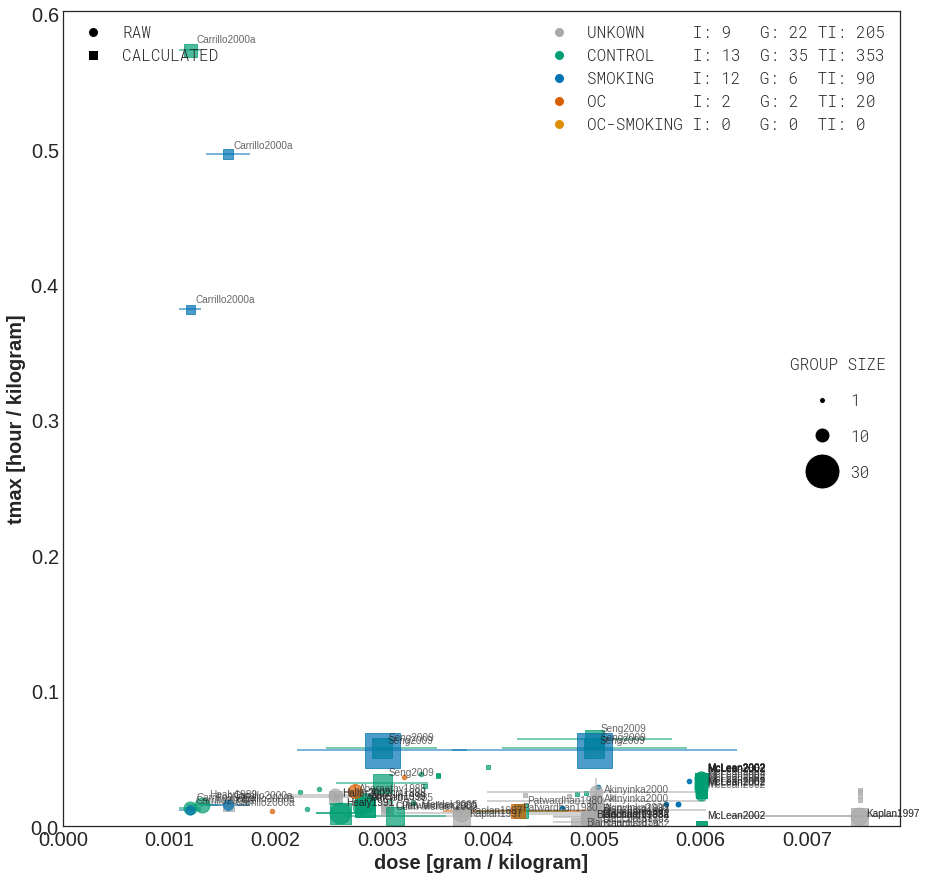

In [26]:
create_plots(caffeine_max,categories_strict,"reports/strict","tmax")

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 4   G: 22 TI: 204
CONTROL    I: 68  G: 54 TI: 666
SMOKING    I: 21  G: 10 TI: 138
OC         I: 2   G: 4  TI: 40 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 8   G: 19 TI: 176
CONTROL    I: 24  G: 41 TI: 410
SMOKING    I: 19  G: 7  TI: 103
OC         I: 2   G: 2  TI: 20 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 4   G: 19 TI: 172
CONTROL    I: 18  G: 38 TI: 386
SMOKING    I: 12  G: 6  TI: 90 
OC         I: 2   G: 2  TI: 20 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 4   G: 19 TI: 172
CONTROL    I: 18  G: 38 TI: 386
SMOKING    I: 12  G: 6  TI: 90 
OC         I: 2   G: 2  TI: 20 


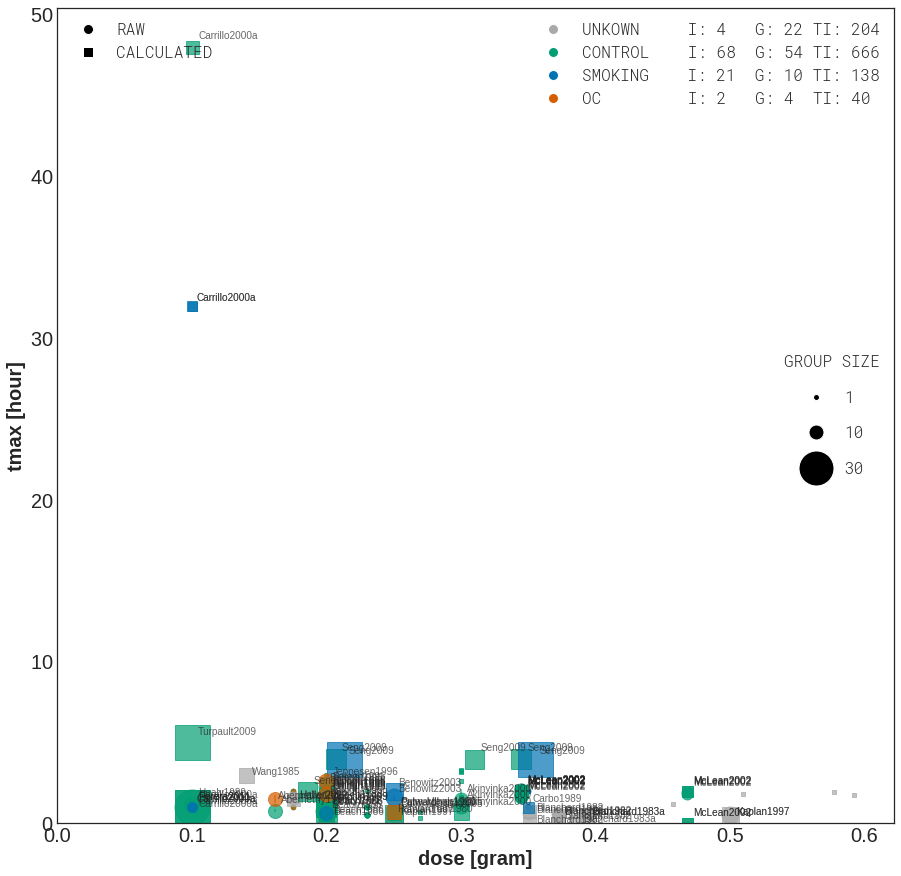

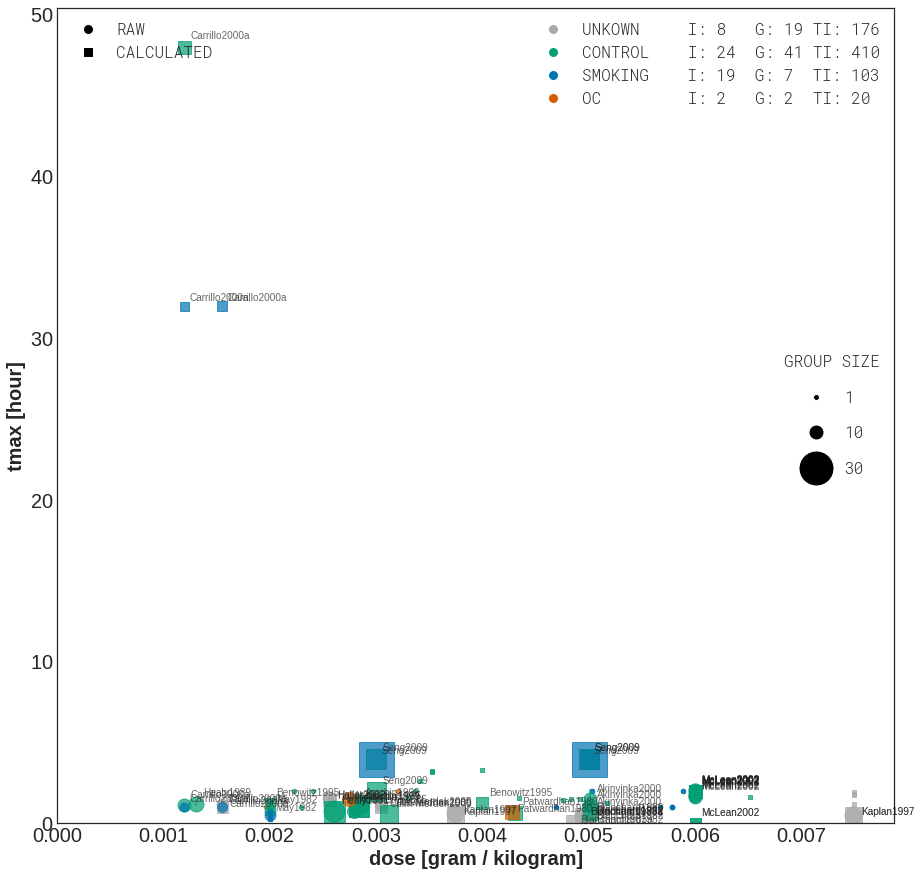

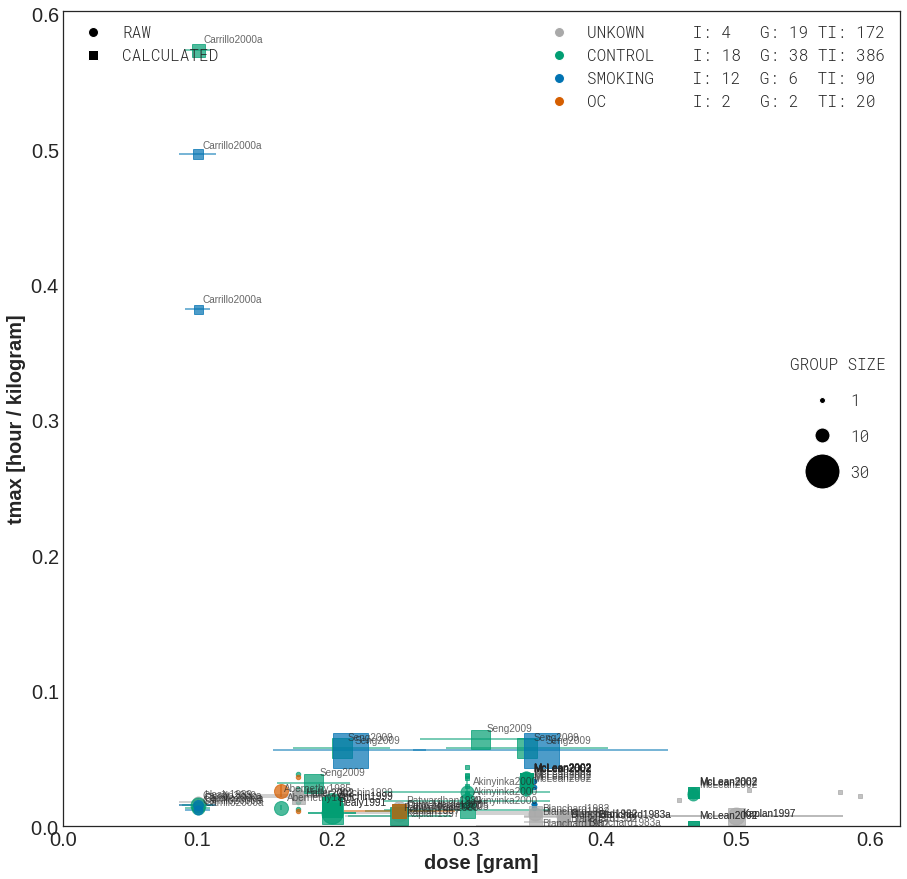

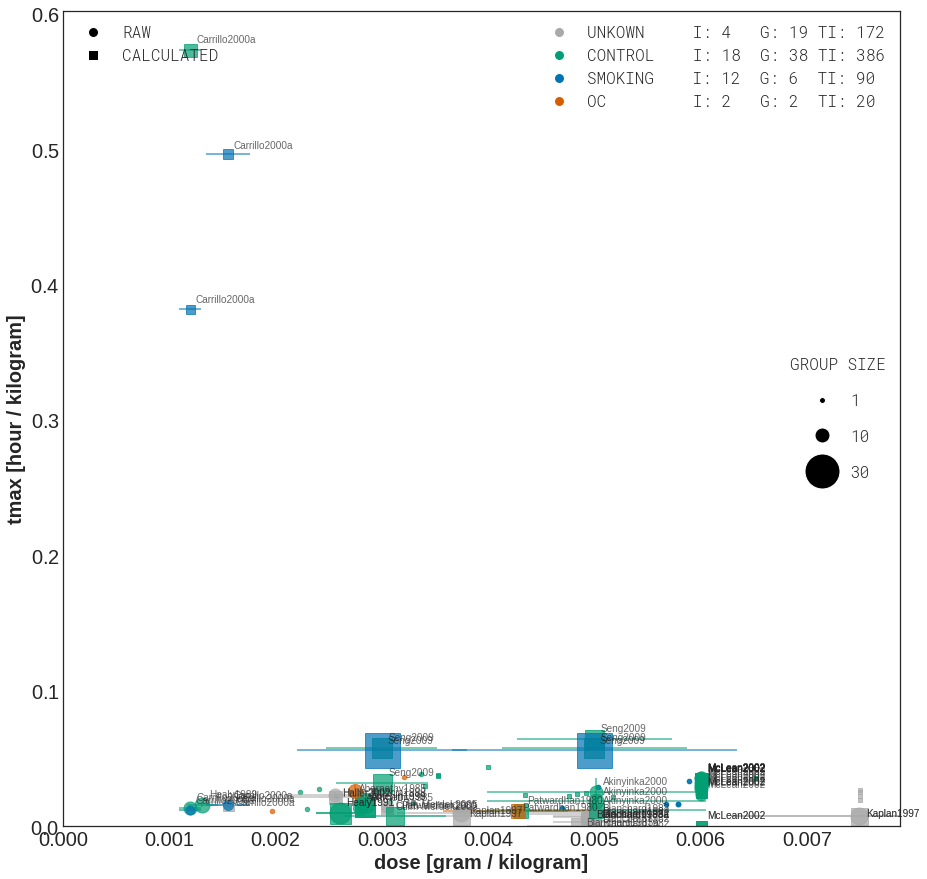

In [27]:
create_plots(caffeine_max,categories_soft,"reports/soft","tmax")

In [28]:
caffeine_instance = PkdbModel("caffeine_vd",destination="3-inferred")
caffeine_instance.read()
caffeine_instance_data = caffeine_instance.data
caffeine_instance_data["outlier"] = False
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Balogh1992","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1988","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1989","outlier"] = True

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 33  G: 46 TI: 398
CONTROL    I: 96  G: 56 TI: 709
SMOKING    I: 63  G: 10 TI: 247
OC         I: 19  G: 6  TI: 75 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 31  G: 39 TI: 330
CONTROL    I: 85  G: 43 TI: 530
SMOKING    I: 55  G: 7  TI: 214
OC         I: 19  G: 4  TI: 55 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 31  G: 46 TI: 417
CONTROL    I: 130 G: 48 TI: 621
SMOKING    I: 55  G: 8  TI: 221
OC         I: 28  G: 4  TI: 64 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 35  G: 39 TI: 334
CONTROL    I: 91  G: 46 TI: 554
SMOKING    I: 62  G: 8  TI: 227
OC         I: 19  G: 4  TI: 55 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 14  G: 41 TI: 344
CONTROL    I: 109 G: 58 TI: 734
SMOKING    I: 78  G: 13 TI: 285
OC         I: 28  G: 6  TI: 84 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 14  G: 37 TI: 297
CONTROL    I: 97  G: 44 TI: 552
SMOKING    I: 69  G: 8  TI: 234
OC         I: 28  G: 4  TI: 64 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 14  G: 43 TI: 376
CONTROL    I: 142 G: 49 TI: 643
SMOKING    I: 69  G: 10 TI: 249
OC         I: 37  G: 4  TI: 73 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 18  G: 37 TI: 301
CONTROL    I: 103 G: 47 TI: 576
SMOKING    I: 76  G: 9  TI: 247
OC         I: 28  G: 4  TI: 64 


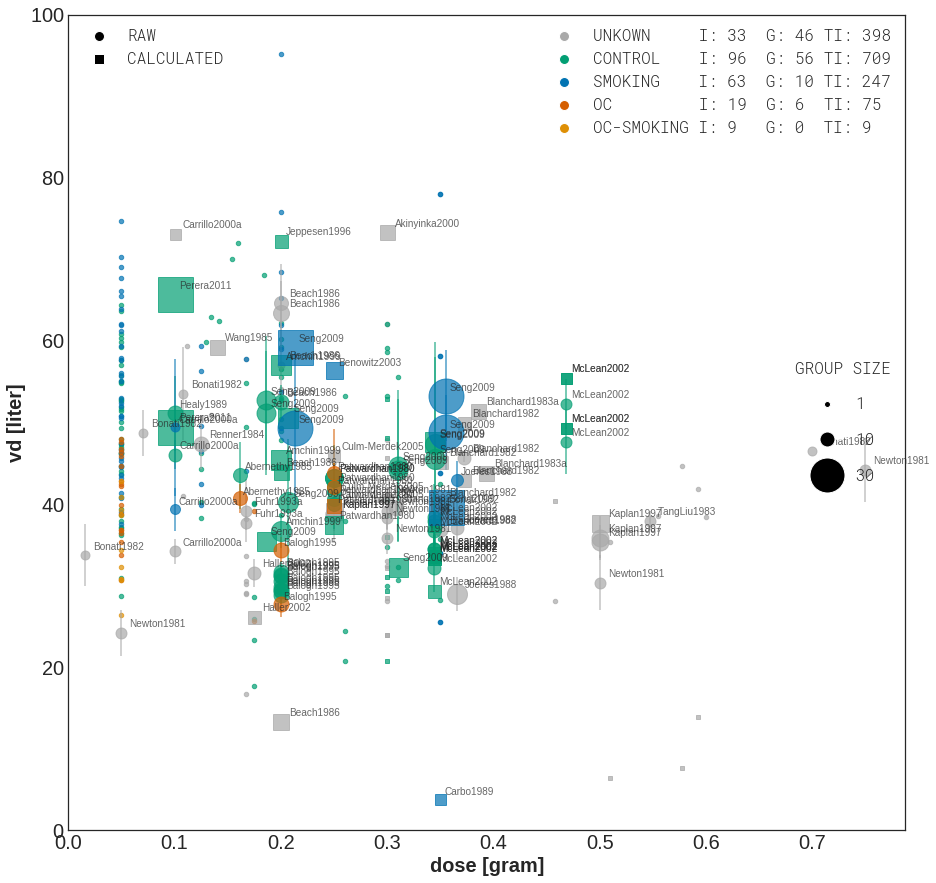

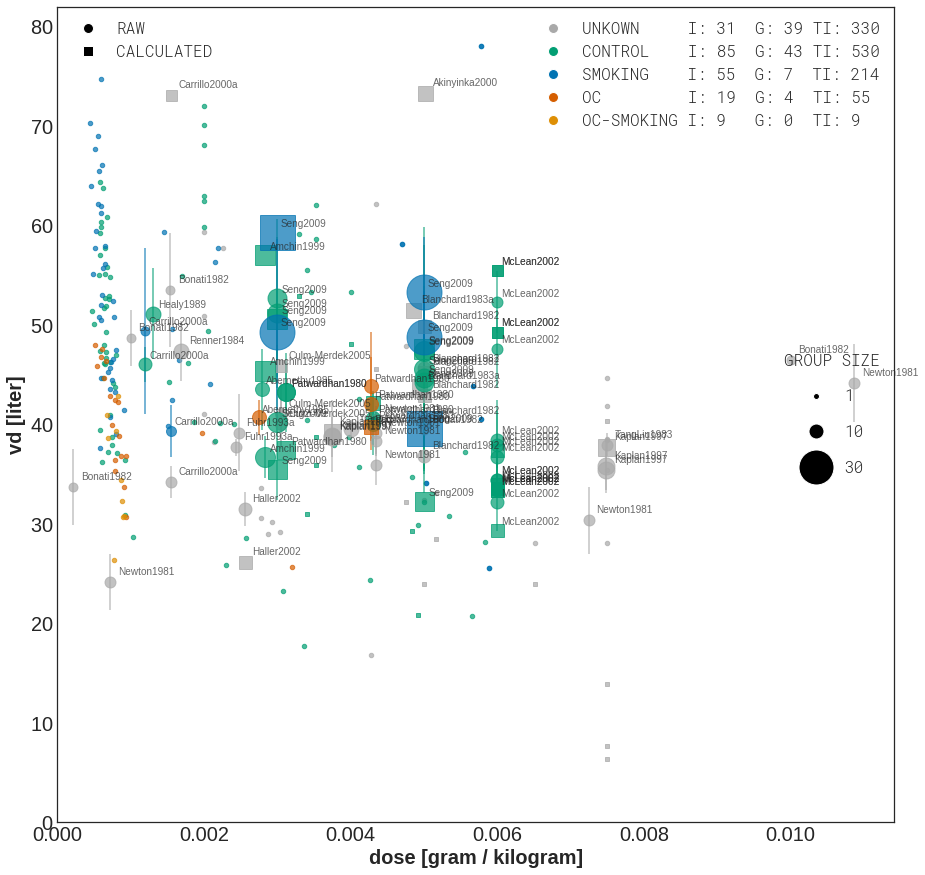

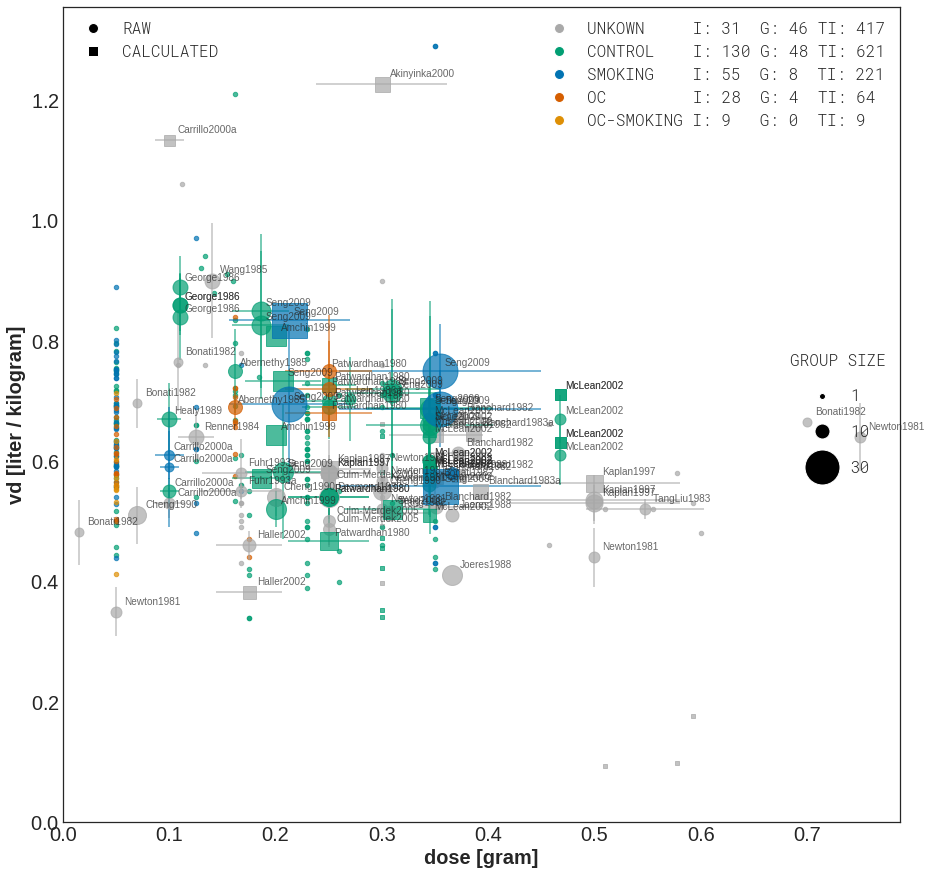

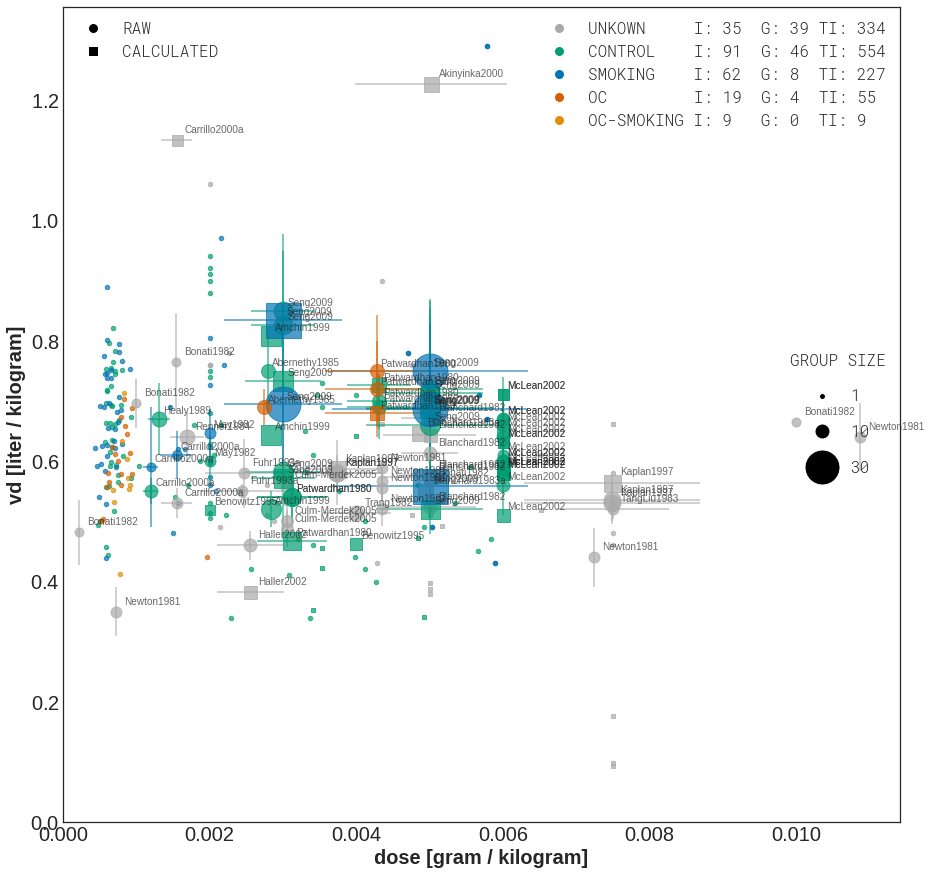

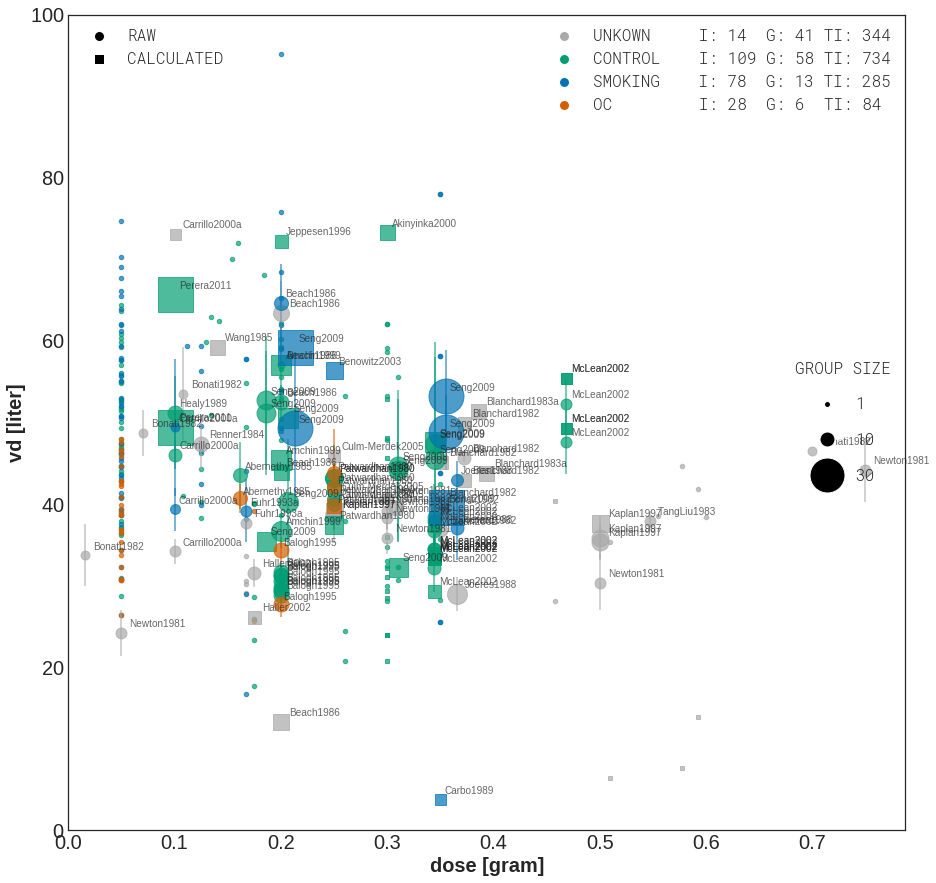

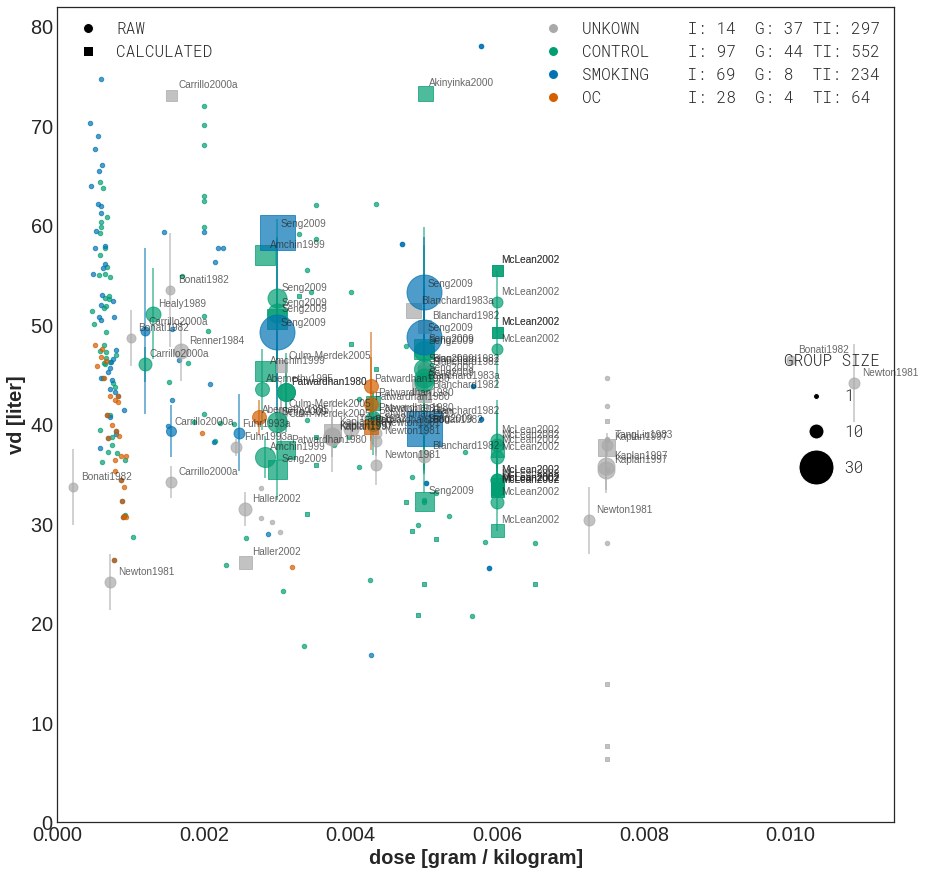

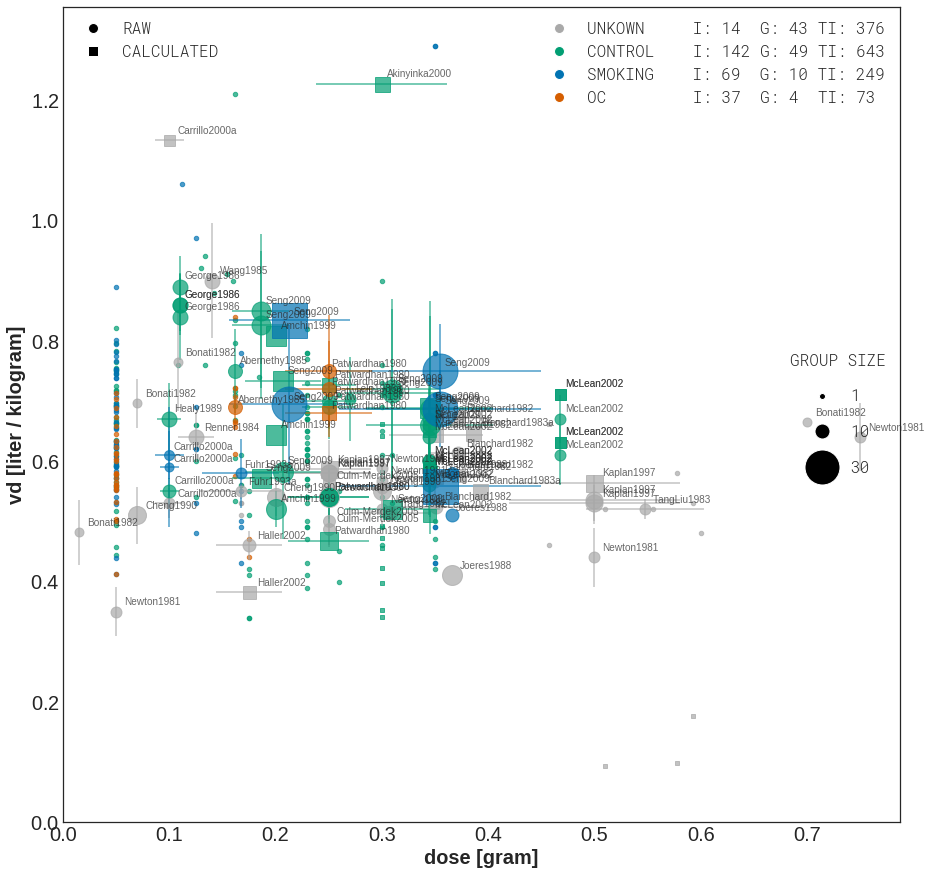

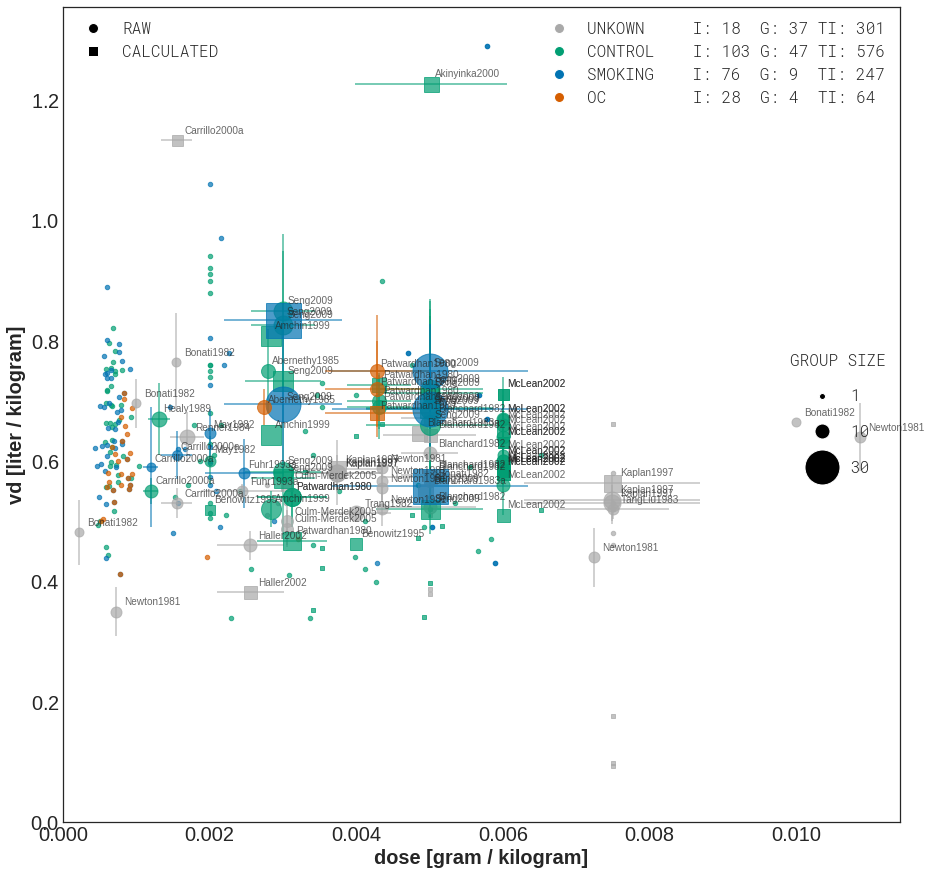

In [29]:
create_plots(caffeine_instance_data,categories_strict,"reports/strict","vd")
create_plots(caffeine_instance_data,categories_soft,"reports/soft","vd")

In [30]:
caffeine_instance = PkdbModel("caffeine_auc_inf",destination="3-inferred")
caffeine_instance.read()
caffeine_instance_data = caffeine_instance.data
caffeine_instance_data["outlier"] = False
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Balogh1992","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1988","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1989","outlier"] = True
caffeine_instance_data.dropna(subset=["value"], inplace=True)

In [31]:
#intermediate = caffeine_instance_data[(caffeine_instance_data["value"].isna() == False)]
#intermediate[intermediate["calculated"]==True]

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:136: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


UNKOWN     I: 19  G: 0  TI: 19 
CONTROL    I: 114 G: 0  TI: 114
SMOKING    I: 49  G: 0  TI: 49 
OC         I: 17  G: 0  TI: 17 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:136: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


UNKOWN     I: 8   G: 0  TI: 8  
CONTROL    I: 0   G: 0  TI: 0  
SMOKING    I: 1   G: 0  TI: 1  
OC         I: 0   G: 0  TI: 0  
OC-SMOKING I: 0   G: 0  TI: 0  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:136: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


UNKOWN     I: 19  G: 0  TI: 19 
CONTROL    I: 78  G: 0  TI: 78 
SMOKING    I: 49  G: 0  TI: 49 
OC         I: 17  G: 0  TI: 17 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:136: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


UNKOWN     I: 4   G: 0  TI: 4  
CONTROL    I: 0   G: 0  TI: 0  
SMOKING    I: 0   G: 0  TI: 0  
OC         I: 0   G: 0  TI: 0  
OC-SMOKING I: 0   G: 0  TI: 0  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:136: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


UNKOWN     I: 4   G: 0  TI: 4  
CONTROL    I: 125 G: 0  TI: 125
SMOKING    I: 62  G: 0  TI: 62 
OC         I: 26  G: 0  TI: 26 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:136: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


UNKOWN     I: 8   G: 0  TI: 8  
CONTROL    I: 0   G: 0  TI: 0  
SMOKING    I: 1   G: 0  TI: 1  
OC         I: 0   G: 0  TI: 0  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:136: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


UNKOWN     I: 4   G: 0  TI: 4  
CONTROL    I: 89  G: 0  TI: 89 
SMOKING    I: 62  G: 0  TI: 62 
OC         I: 26  G: 0  TI: 26 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:136: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


UNKOWN     I: 4   G: 0  TI: 4  
CONTROL    I: 0   G: 0  TI: 0  
SMOKING    I: 0   G: 0  TI: 0  
OC         I: 0   G: 0  TI: 0  


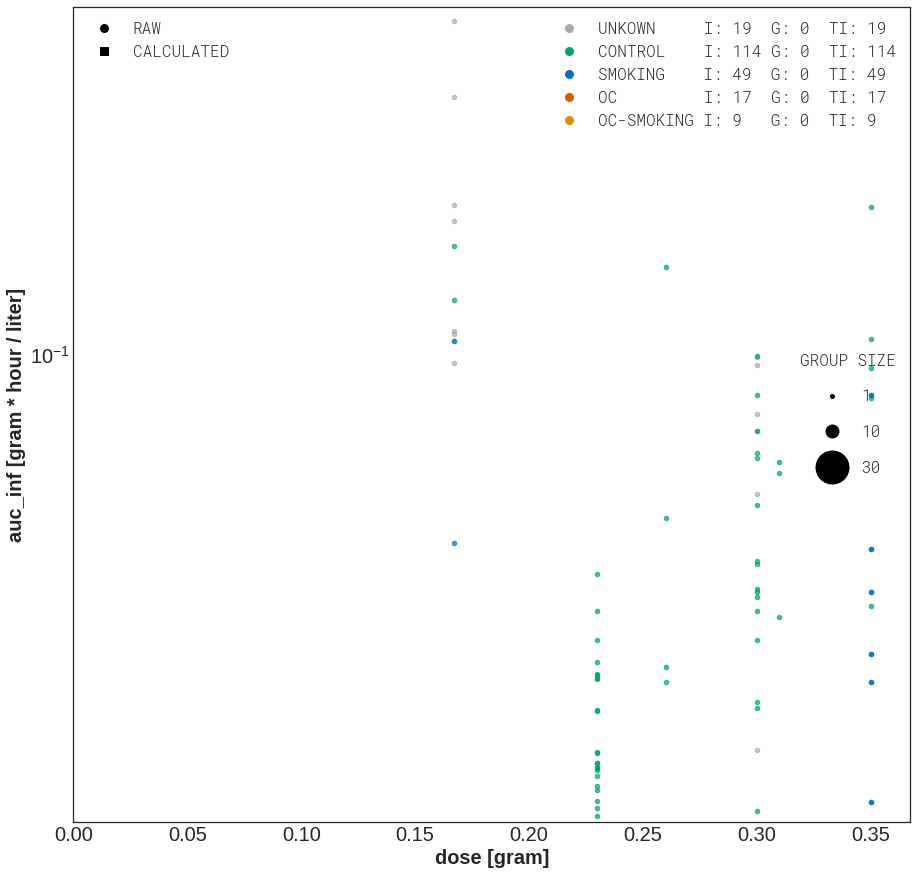

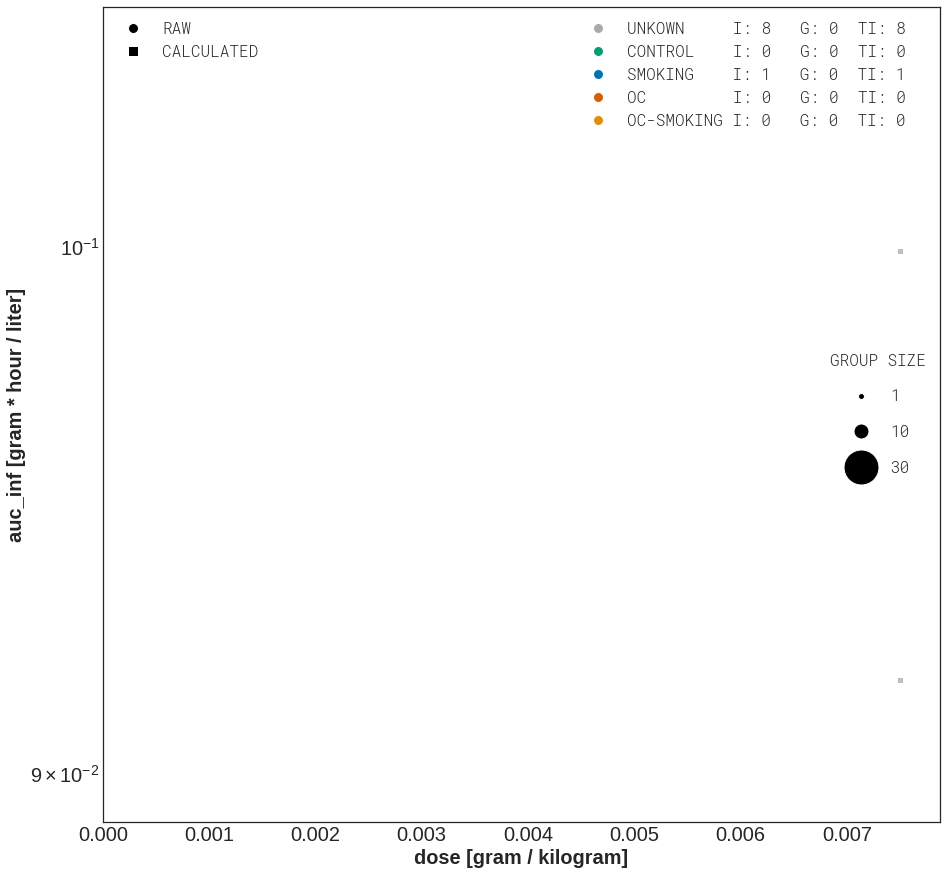

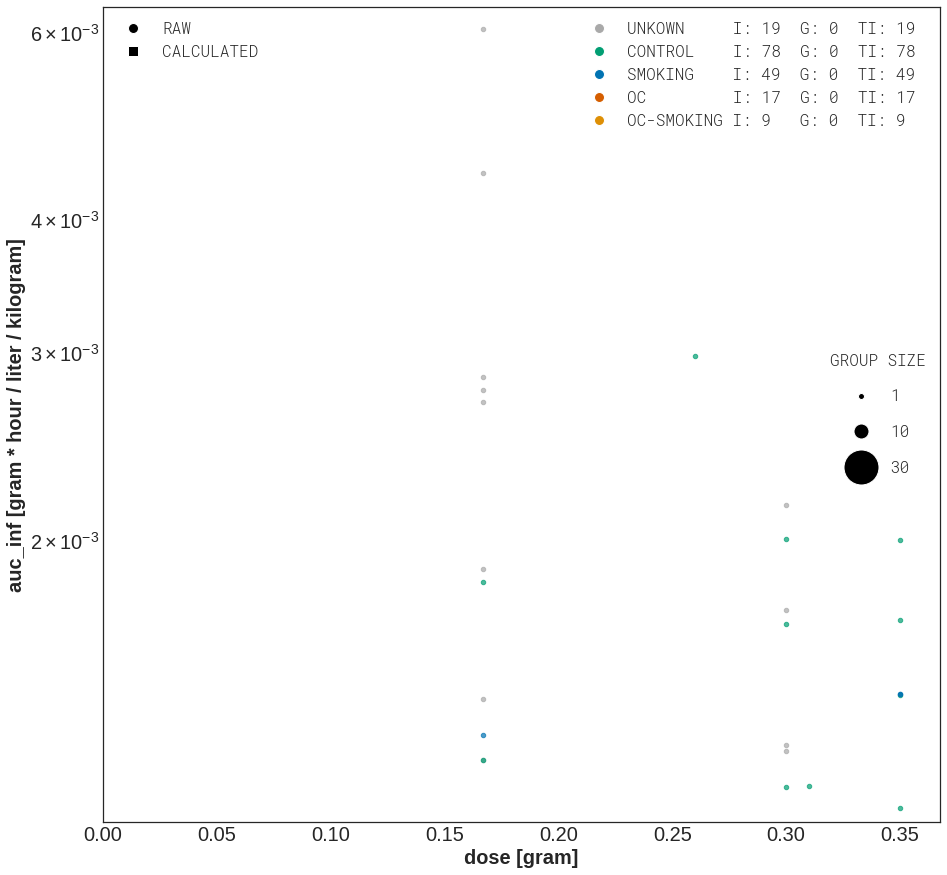

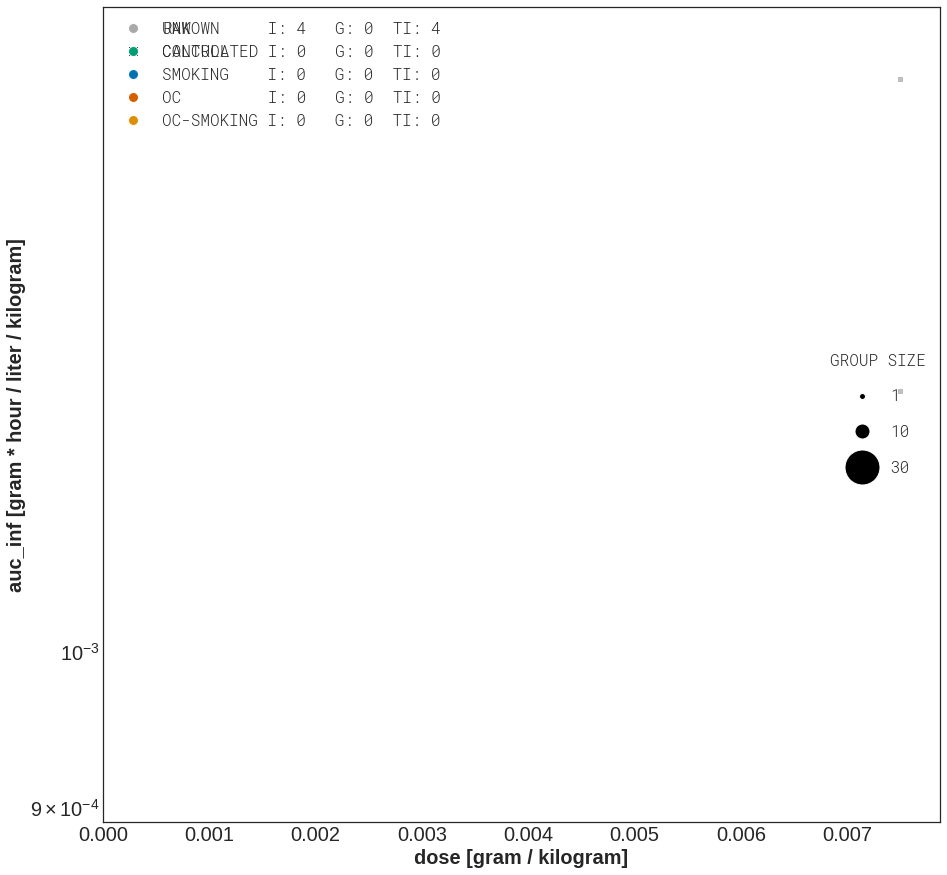

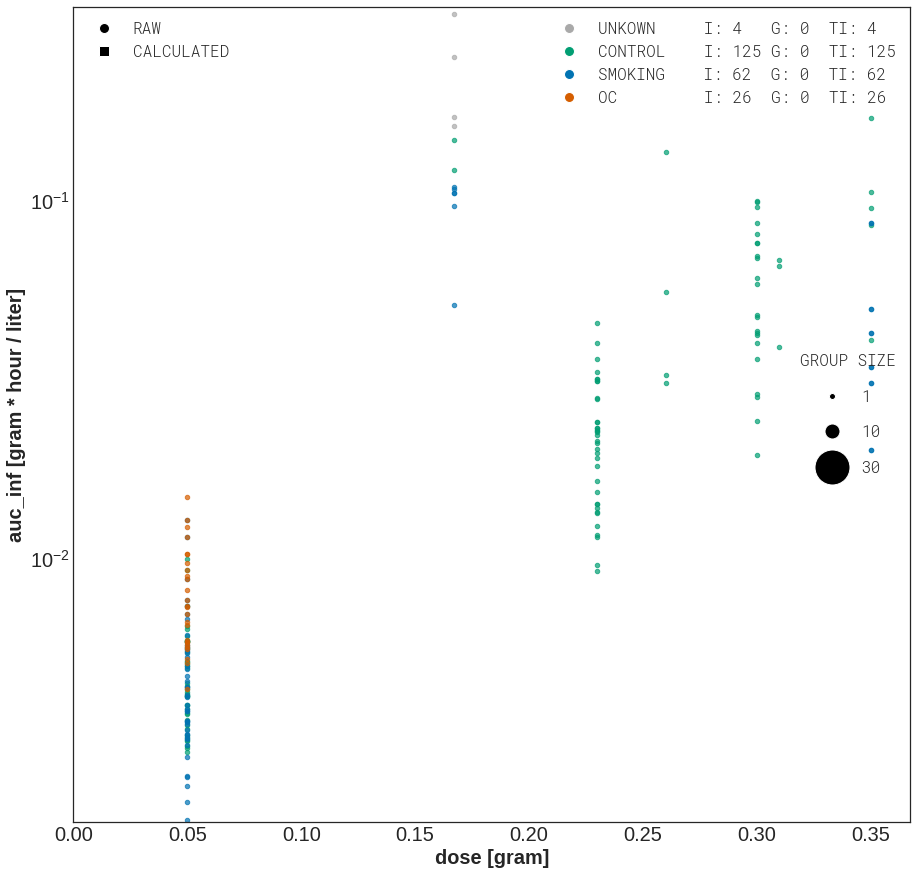

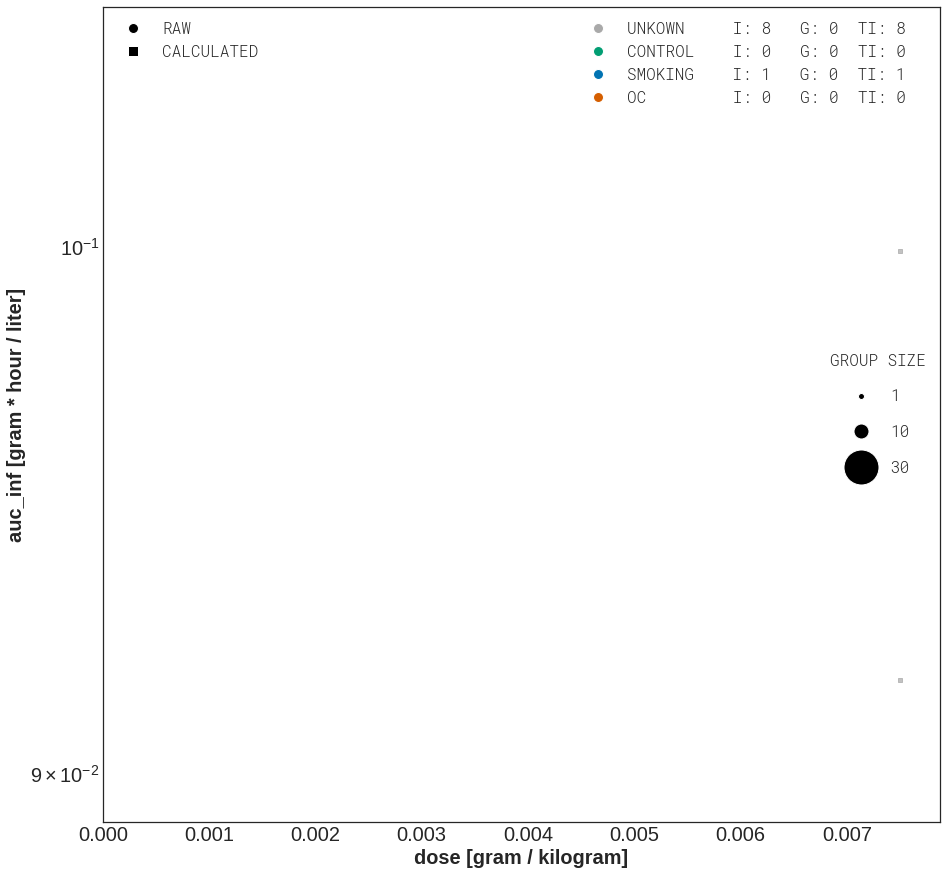

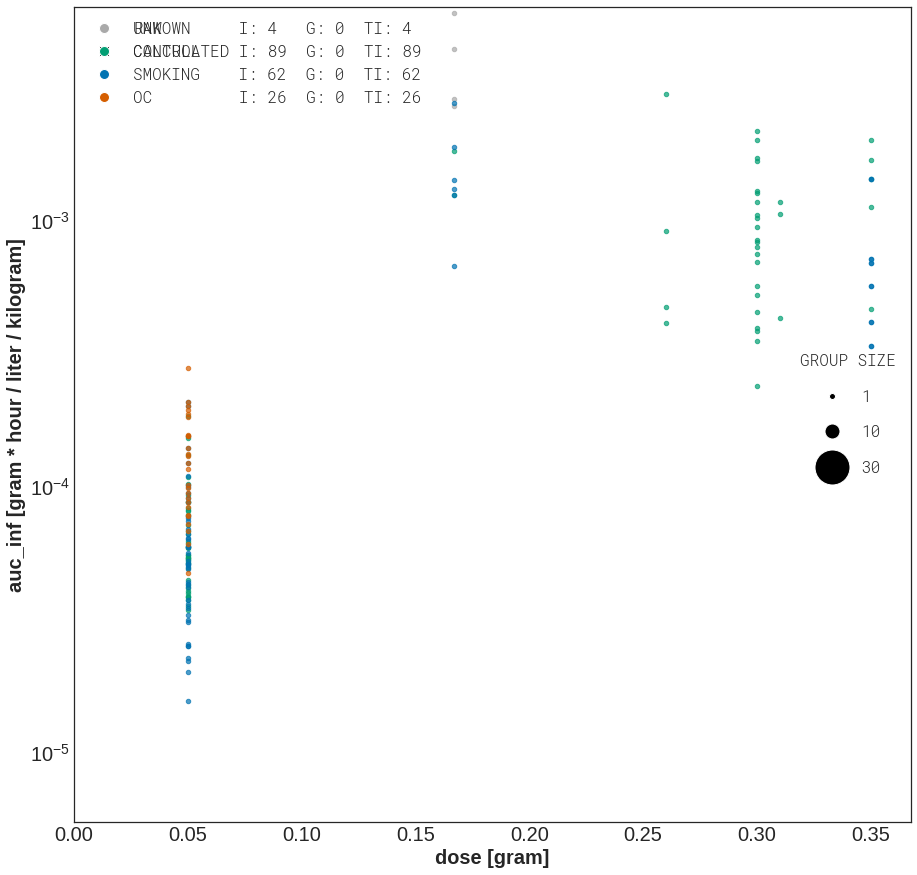

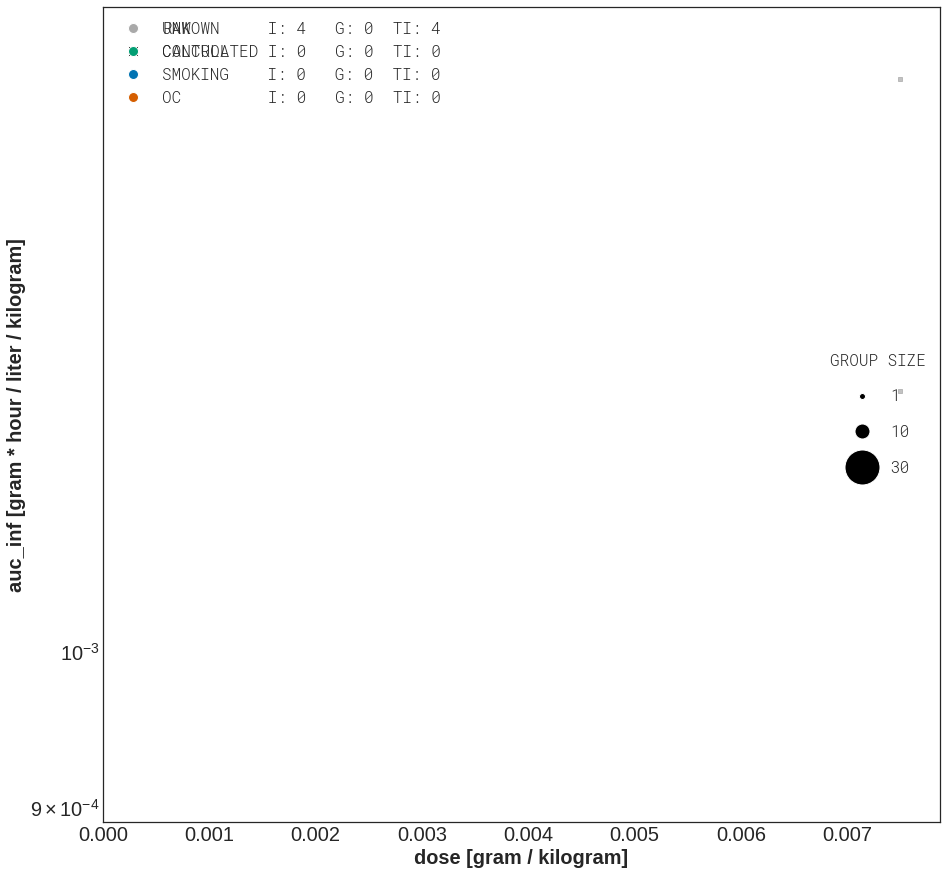

In [32]:
create_plots(caffeine_instance_data,categories_strict,"reports/strict","auc_inf", log_y=True)
create_plots(caffeine_instance_data,categories_soft,"reports/soft","auc_inf", log_y=True)

In [33]:
caffeine_instance = PkdbModel("caffeine_kel",destination="3-inferred")
caffeine_instance.read()
caffeine_instance_data = caffeine_instance.data
caffeine_instance_data["outlier"] = False
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Balogh1992","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1988","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1989","outlier"] = True

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 9   G: 34 TI: 271
CONTROL    I: 53  G: 34 TI: 404
SMOKING    I: 40  G: 5  TI: 123
OC         I: 22  G: 2  TI: 36 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 13  G: 31 TI: 244
CONTROL    I: 53  G: 32 TI: 338
SMOKING    I: 41  G: 3  TI: 106
OC         I: 22  G: 2  TI: 36 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 4   G: 33 TI: 256
CONTROL    I: 58  G: 35 TI: 419
SMOKING    I: 49  G: 5  TI: 132
OC         I: 31  G: 2  TI: 45 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 8   G: 30 TI: 229
CONTROL    I: 58  G: 33 TI: 353
SMOKING    I: 50  G: 3  TI: 115
OC         I: 31  G: 2  TI: 45 


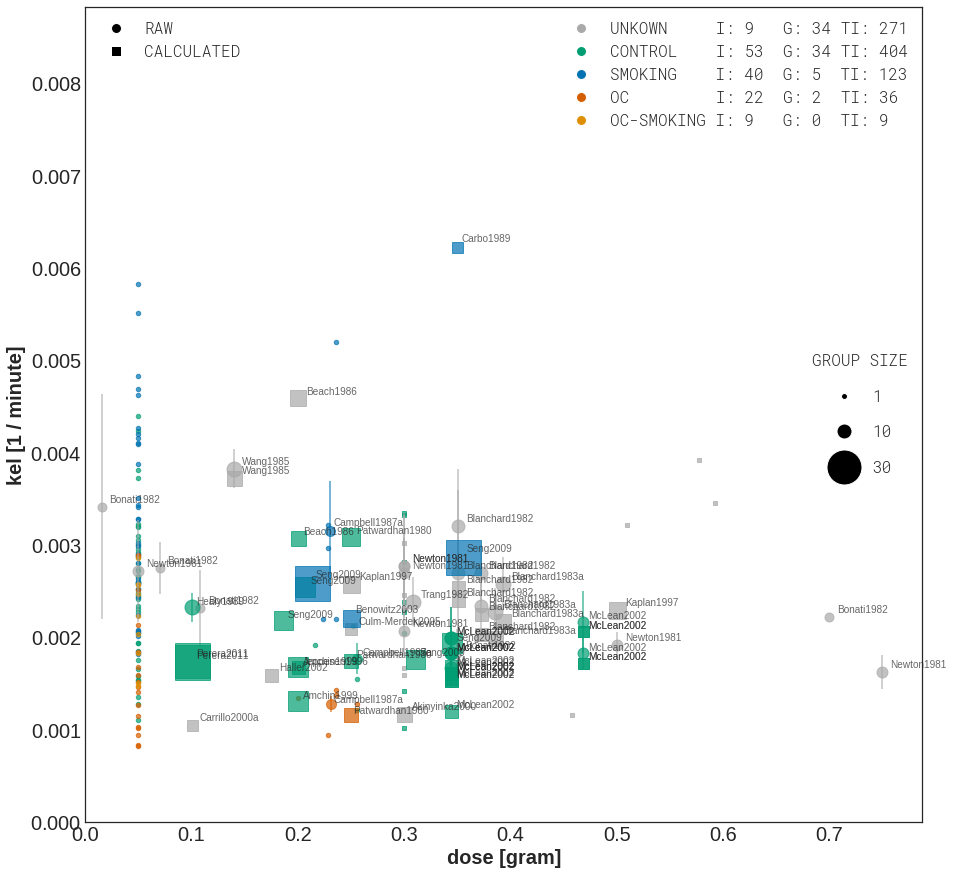

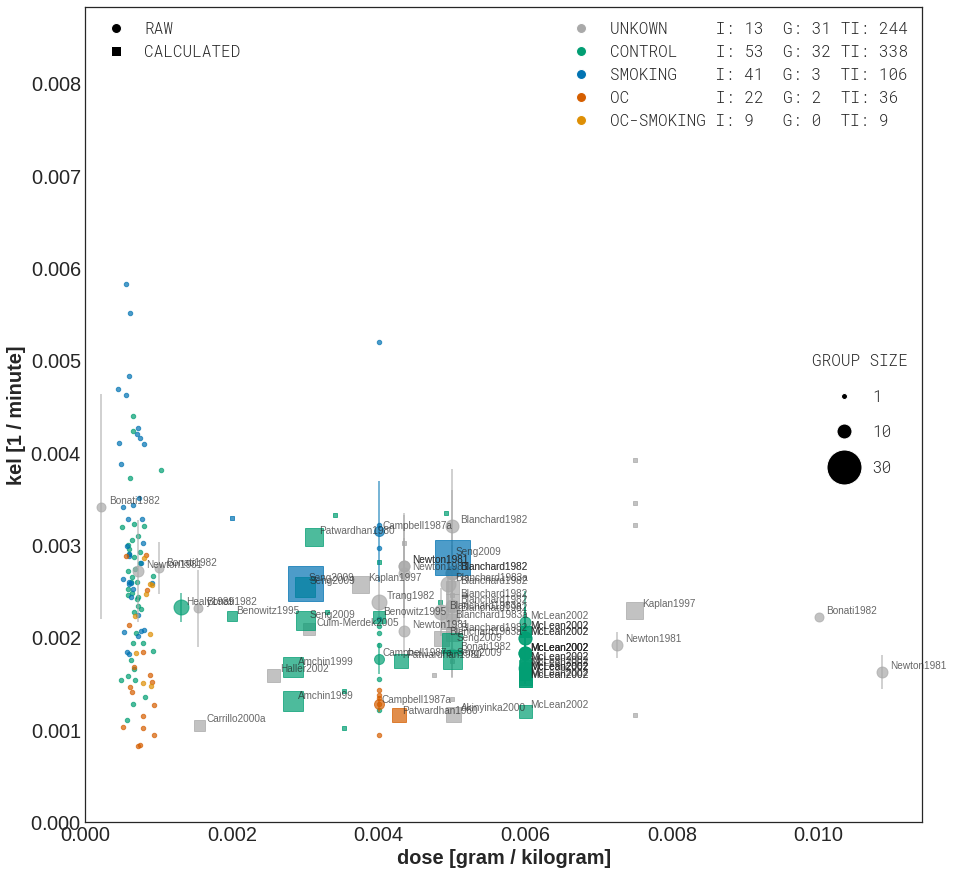

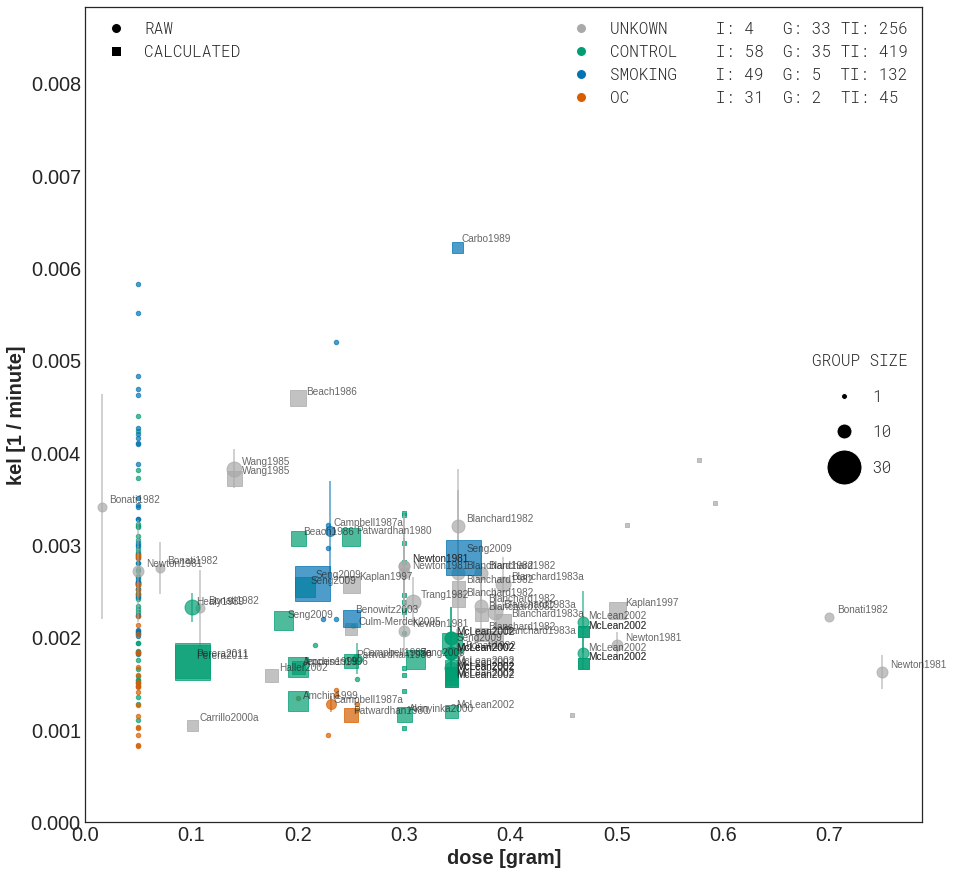

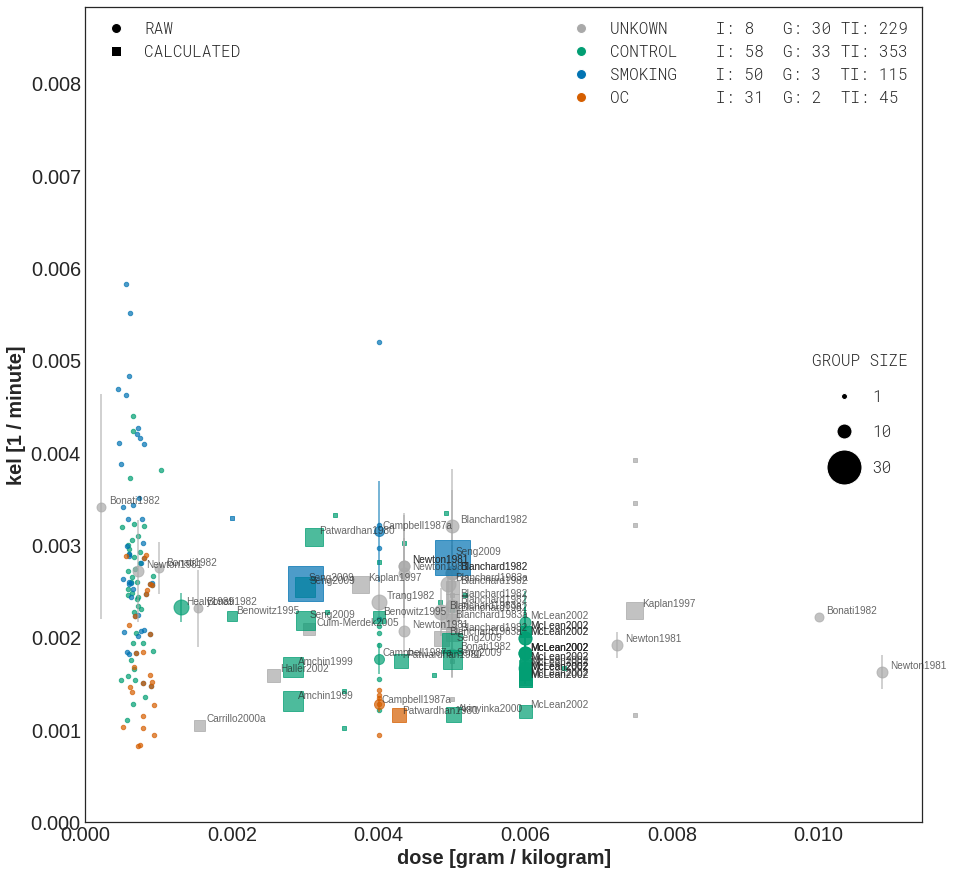

In [34]:
create_plots(caffeine_instance_data,categories_strict,"reports/strict","kel")
create_plots(caffeine_instance_data,categories_soft,"reports/soft","kel")

In [35]:
caffeine_thalf.dropna(axis=0, subset=["group_count"])[["mean", "group_count","sd","se","cv","unit"]]

mean  group_count        sd        se     cv   unit
148   9.890000         10.0       NaN       NaN    NaN     hr
149   7.200000         10.0  3.000000  0.949000  0.417     hr
150   6.000000          8.0  1.700000  0.601000  0.283     hr
151   6.100000         15.0  3.550000  0.917000  0.582     hr
152   8.800000         15.0       NaN       NaN    NaN     hr
153   6.890000         15.0       NaN       NaN    NaN     hr
154   5.370000          9.0       NaN  0.620000  0.346     hr
169   4.300000         10.0  1.020000  0.323000  0.237     hr
170   3.750000         10.0       NaN       NaN    NaN     hr
171   2.520000         11.0       NaN       NaN    NaN     hr
172   2.190000         11.0  0.440000  0.133000  0.201     hr
173   2.090000          9.0  0.410000  0.137000  0.196     hr
174   4.600000         12.0  2.200000  0.635000  0.478     hr
175   5.220000         12.0       NaN       NaN    NaN     hr
176   4.150000         10.0  1.590000  0.503000  0.383     hr
177   3.960000         10.0  1.210000  0.383000  0.306     hr
178   3.320000         10.0  0.840000  0.266000  0.253     hr
179   4.190000         10.0  1.260000  0.398000  0.301     hr
180   4.820000         10.0  2.410000  0.762000  0.500     hr
181   4.700000         10.0  1.520000  0.481000  0.323     hr
182   4.440000         10.0  1.480000  0.468000  0.333     hr
183   4.660000         10.0  2.110000  0.667000  0.453     hr
184   9.150000         10.0  2.650000  0.838000  0.290     hr
185   4.530000          8.0       NaN       NaN    NaN     hr
186   3.700000          8.0       NaN       NaN    NaN     hr
187   3.620000          8.0       NaN       NaN    NaN     hr
188   4.790000          8.0       NaN       NaN    NaN     hr
189   5.110000          8.0       NaN       NaN    NaN     hr
190   4.940000          8.0       NaN       NaN    NaN     hr
191   4.280000          8.0       NaN       NaN    NaN     hr
...        ...          ...       ...       ...    ...    ...
2007  0.144077          8.0       NaN  0.020035  0.393  hr/kg
2008  0.125784          8.0       NaN  0.012369  0.278  hr/kg
2009  0.124216          8.0       NaN       NaN    NaN  hr/kg
2010  0.128746          8.0       NaN       NaN    NaN  hr/kg
2011  0.124216          8.0       NaN       NaN    NaN  hr/kg
2012  0.120557          8.0       NaN  0.014808  0.347  hr/kg
2013  0.125261          8.0       NaN  0.012021  0.271  hr/kg
2014  0.130836          8.0       NaN       NaN    NaN  hr/kg
2015  0.071538          6.0       NaN       NaN    NaN  hr/kg
2016  0.085513          6.0       NaN       NaN    NaN  hr/kg
2017  0.080513          6.0       NaN  0.007051  0.215  hr/kg
2018  0.071538          6.0       NaN       NaN    NaN  hr/kg
2019  0.085513          6.0       NaN       NaN    NaN  hr/kg
2020  0.073077          6.0       NaN  0.009615  0.322  hr/kg
2021  0.073973          6.0  0.034247  0.013973  0.463  hr/kg
2022  0.059296         30.0  0.020000  0.003648  0.337  hr/kg
2023  0.072113         30.0  0.015211  0.002775  0.211  hr/kg
2024  0.062676         30.0       NaN       NaN    NaN  hr/kg
2025  0.056761         30.0       NaN       NaN    NaN  hr/kg
2026  0.080580         15.0  0.031304  0.008087  0.388  hr/kg
2027  0.065652         15.0       NaN       NaN    NaN  hr/kg
2028  0.070435         15.0  0.023043  0.005957  0.327  hr/kg
2029  0.086377         15.0       NaN       NaN    NaN  hr/kg
2030  0.105161         14.0       NaN       NaN    NaN  hr/kg
2031  0.082581         14.0  0.048871  0.013065  0.592  hr/kg
2032  0.085000         14.0       NaN       NaN    NaN  hr/kg
2033  0.077258         14.0  0.036290  0.009694  0.470  hr/kg
2034  0.062857         10.0       NaN       NaN    NaN  hr/kg
2035  0.106250          5.0       NaN  0.012500  0.263  hr/kg
2036  0.069444          5.0       NaN  0.010417  0.335  hr/kg

[453 rows x 6 columns]

In [36]:
caffeine_absolute = caffeine_thalf[caffeine_thalf["unit"]=="hour"]
caffeine_absolute = caffeine_absolute[caffeine_absolute["unit_intervention"] == "gram / kilogram"]

caffeine_absolute = caffeine_absolute[~caffeine_absolute["outlier"]]

caffeine_absolute = caffeine_absolute.dropna(subset=["value"])


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
No handles with labels found to put in legend.


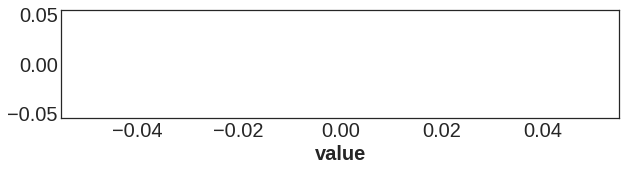

In [37]:

plt.figure(figsize= (10,2))
sns.distplot(caffeine_absolute[smoking_idx(caffeine_absolute)]["value"], bins=None,   color="blue");
sns.distplot(caffeine_absolute[oc_idx(caffeine_absolute)]["value"], bins=None,  color="green");
#sns.distplot(caffeine_absolute[oc_smoking_strict(caffeine_absolute)]["value"], bins=20,   label="oc_smoking");
sns.distplot(caffeine_absolute[control_idx(caffeine_absolute)]["value"], bins=None, color="black");
#sns.distplot(caffeine_thalf[rest_idx(caffeine_thalf)]["value"], bins=20, kde=False, label="unknown");

plt.legend()



In [44]:

caffeine_absolute = caffeine_thalf[caffeine_thalf["unit"]=="hr"]
caffeine_absolute = caffeine_absolute[caffeine_absolute["unit_intervention"] == "mg"]
caffeine_absolute = caffeine_absolute.dropna(subset=["mean"])
caffeine_absolute = caffeine_absolute[~caffeine_absolute["outlier"]]

frames = []
for i, data in caffeine_absolute.iterrows():
    for _ in range(int(data["group_count"])):
        data["value"] = data["mean"]
        frames.append(data)

caffeine_absolute1 =  pd.concat(frames, axis=1).T


frames = []
for i, data in caffeine_absolute.iterrows():
    mean = data["mean"]
    sd = data["sd"]
    for _ in range(int(data["group_count"])):
        
        if not np.isnan(sd):
            value = -1

            while value < 0:
                value = np.random.normal(mean,sd)
            data["value"] = value

            

        else:
            data["value"] = data["mean"]
            
        frames.append(data)

caffeine_absolute2 =  pd.concat(frames, axis=1).T


In [45]:
len(caffeine_absolute2)

1304

In [46]:
caffeine_absolute = caffeine_thalf[caffeine_thalf["unit"]=="hour"]
caffeine_absolute = caffeine_absolute[caffeine_absolute["unit_intervention"] == "gram"]
caffeine_absolute = caffeine_absolute[~caffeine_absolute["outlier"]]
len(caffeine_absolute)

0

In [47]:
#caffeine_absolute = caffeine_absolute1
#caffeine_absolute = caffeine_absolute2
#caffeine_absolute = caffeine_absolute.reset_index()

caffeine_absolute = caffeine_absolute.dropna(subset=["value"]).append(caffeine_absolute1)
len(caffeine_absolute)

1304

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


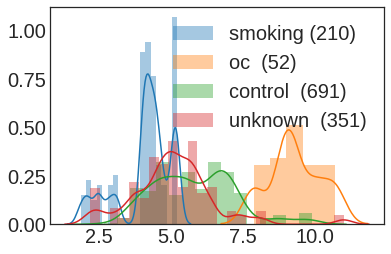

In [48]:
smoking = caffeine_absolute[smoking_idx(caffeine_absolute)]["value"].to_list()
oc = caffeine_absolute[oc_idx(caffeine_absolute)]["value"].to_list()
control = caffeine_absolute[control_idx(caffeine_absolute)]["value"].to_list()
rest = caffeine_absolute[rest_idx(caffeine_absolute)]["value"].to_list()

sns.distplot(smoking, bins=None,   label=f"smoking ({len(smoking)})")
sns.distplot(oc, bins=None,  label=f"oc  ({len(oc)})")
sns.distplot(control, bins=None, label=f"control  ({len(control)})")
sns.distplot(rest, bins=None, label=f"unknown  ({len(rest)})")

plt.legend()

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


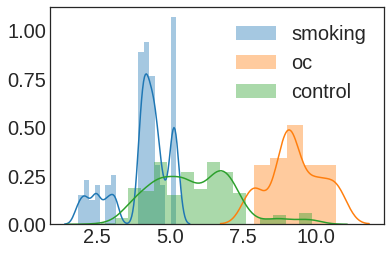

In [49]:
#caffeine_absolute = caffeine_absolute1
caffeine_absolute = caffeine_absolute1
caffeine_absolute = caffeine_absolute.reset_index()

sns.distplot(caffeine_absolute[smoking_idx(caffeine_absolute)]["mean"].to_list(), bins=None,   label="smoking")
sns.distplot(caffeine_absolute[oc_idx(caffeine_absolute)]["mean"].to_list(), bins=None,  label="oc")
sns.distplot(caffeine_absolute[control_idx(caffeine_absolute)]["mean"].to_list(), bins=None, label="control")
plt.legend()

In [50]:
caffeine_instance = PkdbModel("caffeine_vd",destination="3-inferred")
caffeine_instance.read()
caffeine_instance_data = caffeine_instance.data
caffeine_instance_data["outlier"] = False
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Balogh1992","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1988","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1989","outlier"] = True

In [51]:
caffeine_instance_data.columns.to_list()

#yinterp = interpolate.UnivariateSpline(x, y, s = 5e8)(x) 


['study',
 'output_type',
 'pk',
 'access',
 'measurement_type',
 'tissue',
 'allowed_users',
 'substance',
 'interventions',
 'raw_pk',
 'unit',
 'calculated',
 'individual_name',
 'individual_pk',
 'value',
 'group_pk',
 'group_name',
 'group_count',
 'mean',
 'timecourse_pk',
 'time_unit',
 'time',
 'se',
 'cv',
 'sd',
 'pharmacokinetics',
 'figure',
 'max',
 'min',
 'median',
 'choice',
 'raw_pk_intervention',
 'allowed_users_intervention',
 'measurement_type_intervention',
 'access_intervention',
 'route',
 'substance_intervention',
 'unit_intervention',
 'value_intervention',
 'application',
 'time_intervention',
 'time_unit_intervention',
 'form',
 'choice_intervention',
 'min_intervention',
 'max_intervention',
 'se_intervention',
 'sd_intervention',
 'subject_type',
 'subject_pk',
 ('study', ''),
 ('subject_name', ''),
 ('species', 'choice'),
 ('species', 'count'),
 ('healthy', 'choice'),
 ('healthy', 'count'),
 ('sex', 'choice'),
 ('sex', 'count'),
 ('age', 'count'),
 ('age',

In [53]:
import matplotlib.pyplot as plt
from scipy import interpolate

unit_intervention = "gram"
unit = "liter / hour"

caffeine_abs_abs= caffeine_clearance[(caffeine_clearance["unit_intervention"] == unit_intervention) &(caffeine_clearance["unit"] == unit)]#[["value","value_intervention"]]
caffeine_abs_abs["value"] = caffeine_abs_abs["mean"]
for category in categories_soft:
    d = caffeine_abs_abs[category.data_idx(caffeine_abs_abs)]
    d.sort_values("value_intervention", inplace=True)
    linear_fit = np.polyfit(d["value_intervention"], d["value"], 3)
    #sns.regplot("value_intervention","value", d, order=3,truncate=True, label =category.name,)
    
    #yinterp = interpolate.UnivariateSpline(d["value_intervention"],d["value"], s = 5e8)(d["value_intervention"]) 
    #plt.plot(x, y, 'bo', label = 'Original')
    #plt.plot(x, yinterp, 'r', label = 'Interpolated'
plt.legend()

TypeError: expected non-empty vector for x

In [54]:
caffeine_clearance[(caffeine_clearance["outlier"] == False) &
(caffeine_clearance["unit_intervention"] == "gram / kilogram") &(caffeine_clearance["unit"] == "liter / hour / kilogram")].sort_values("value",ascending=False)[["study","value"]]

Empty DataFrame
Columns: [study, value]
Index: []